Fundamentos de analítica 2 (clase 4) - Diego Fernando Agudelo - Universidad ICESI - diegoagudelo30@gmail.com

# Fundamentos-analitica-II
Repositorio de trabajos para la asignatura de la maestría en Ciencia de Datos

FACULTAD DE INGENIERÍA, DISEÑO Y CIENCIAS 
APLICADAS 
MAESTRÍA EN CIENCIA DE DATOS 
TIC 60153 – Fundamentos de analítica II 

Grupo: 

**DANIEL DELGADO - FABIAN SALAZAR FIGUEROA**

En días recientes trabajamos con una compañía de comestibles que estaba interesada en predecir el comportamiento de las ventas (en unidades) de sus dos productos estrella. Fuimos contratados para generar un modelo que permita pronosticar las ventas del siguiente mes de cada uno de esos dos productos. La base de datos disponible en el archivo Examen.csv tiene la información de cada uno de los productos desde enero de 2008.

Su misión es encontrar el mejor modelo para pronosticar cada una de las series. Usted debe entregar un informe escrito de no más de cuatro páginas que presente los resultados al cliente y cuente el proceso para llegar a los pronósticos. Vea las instrucciones para asegurar que entrega los archivos requeridos

### Instrucciones
El examen se compone de dos partes:
- La primera corresponde a una parte de selección múltiple con 19 preguntas que se responderán en el salón de clase en 45 minutos. Esa primera parte tiene una calificación de 1 a 5.
-La segunda parte corresponde a la parte práctica del examen y tiene también una calificación de 1 a 5.

- La nota de este examen parcial corresponderá al promedio ponderado de las dos notas, donde la parte práctica tiene un peso de 40 % y la parte de selección múltiple de 60 %.
- Usted tiene hasta el 15 de Septiembre a las 12:00 pm para enviar los archivos por correo, estos archivos deben tener su nombre.
- Sólo se calificaran exámenes en formato pdf. Cualquier otro formato no será tenido en cuenta.
- El examen debe estar acompañado de un notebook (ipynb)  que incluya todo los códigos de python que se emplean para obtener sus resultados.
- El nombre del archivo debe tener su nombre. No se recibirán archivos en otro formato.
- Esta parte del examen es para realizar en casa y debe reflejar el trabajo individual.

## **1. Carga de paquetes**

In [45]:
import seaborn as sns
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error
#!pip install fastai wwf bayesian-optimization -q --upgrade
from bayes_opt import BayesianOptimization
from datetime import datetime, timedelta
from calendar import monthrange
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
# Ignorar advertencias de futuro, usuario, y convergencia (comunes en modelos como ARIMA)
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Importar LinAlgError desde numpy
from numpy.linalg import LinAlgError
import statsmodels.api as sm
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import acorr_ljungbox

## **2. Carga de datos**

Nuestra primera tarea será leer el archivo csv. Para eso podemos emplear el paquete Pandas. Carguemos los datos en un objeto que denominaremos data.

In [2]:
data = pd.read_csv(r"https://raw.githubusercontent.com/alfa7g7/Fundamentos-analitica-II/main/UNIDAD%20I/Clase%204/Examen.csv", sep=',')
data.head()

,Unnamed: 0,producto1,producto2
0,1,4000.000000,3000.000000
1,2,3997.400893,3010.686220
2,3,3978.605317,3022.018584
3,4,3986.454125,3033.920990
4,5,3979.695678,3038.402098


(127, 3)


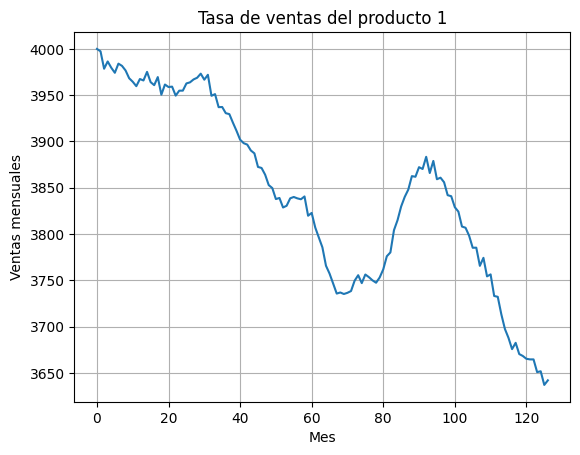

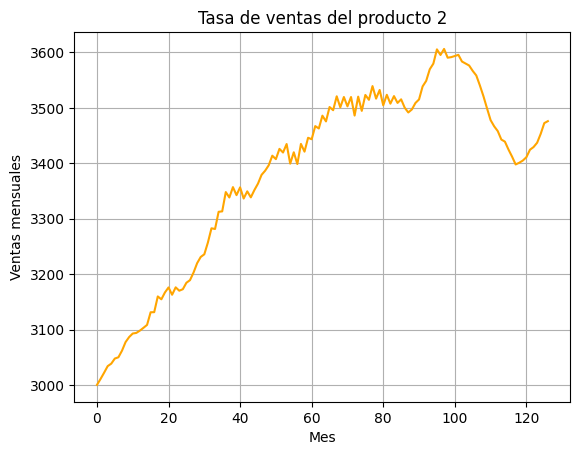

In [3]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos de producto1 y produto2
plt.title("Tasa de ventas del producto 1")
plt.xlabel("Mes")
plt.ylabel("Ventas mensuales")
plt.plot(data[["producto1"]])
plt.grid()
plt.show()

plt.title("Tasa de ventas del producto 2")
plt.xlabel("Mes")
plt.ylabel("Ventas mensuales")
plt.plot(data[["producto2"]], color='orange')
plt.grid()
plt.show()

## **3. EDA**

### 3.1 Procedemos a hacer un análisis corto de EDA para verificar tamaño del conjunto de datos para cada serie de tiempo, nulos (si hay) y algunas cuantificaciones estadísticas

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  127 non-null    int64  
 1   producto1   127 non-null    float64
 2   producto2   127 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 3.1 KB


In [5]:
#Determinamos si existen nulos en las series de tiempo
data.isnull().sum()

Unnamed: 0    0
producto1     0
producto2     0
dtype: int64

In [6]:
# Estadsiticas del conjunto de datos de tendencia central
data.describe()

,Unnamed: 0,producto1,producto2
count,127.000000,127.000000,127.000000
mean,64.000000,3843.571660,3381.037664
std,36.805797,100.234821,167.504363
min,1.000000,3637.047639,3000.000000
25%,32.500000,3756.853812,3269.194001
50%,64.000000,3840.644019,3426.048401
75%,95.500000,3950.071775,3508.941718
max,127.000000,4000.000000,3606.440615


### 3.2 Ahora debemos convertir en índice la variable sin nombre: 'Unnamed: 0'  que representa los meses desde enero del 2008 como lo indica el enunciado del problema y expresarla en forma de fecha para mejorar el entendimiento y procesamiento

In [7]:
# Renombrar la columna 'Unnamed: 0' a 'Mes'
data.rename(columns={'Unnamed: 0': 'Mes'}, inplace=True)

# Función para convertir un número de mes a la última fecha de cada mes
def convertir_mes_a_fecha_final(mes, start_date):
    year = start_date.year + (mes - 1) // 12
    month = (start_date.month + (mes - 1) % 12 - 1) % 12 + 1
    #Obtener el último día del mes
    last_day = monthrange(year, month)[1]
    return datetime(year, month, last_day)

# Fecha de inicio (enero de 2008)
start_date = datetime(2008, 1, 1)

# Aplicar la función a la columna 'Mes'
data['Mes'] = data['Mes'].apply(lambda x: convertir_mes_a_fecha_final(x, start_date))

print(data)


           Mes    producto1    producto2
0   2008-01-31  4000.000000  3000.000000
1   2008-02-29  3997.400893  3010.686220
2   2008-03-31  3978.605317  3022.018584
3   2008-04-30  3986.454125  3033.920990
4   2008-05-31  3979.695678  3038.402098
..         ...          ...          ...
122 2018-03-31  3664.610771  3429.293034
123 2018-04-30  3650.881839  3437.099467
124 2018-05-31  3651.788470  3453.155282
125 2018-06-30  3637.047639  3472.528345
126 2018-07-31  3641.990873  3476.058092

[127 rows x 3 columns]


In [8]:
# Establecer la columna 'Mes' como índice
data.set_index('Mes', inplace=True)

print(data)

              producto1    producto2
Mes                                 
2008-01-31  4000.000000  3000.000000
2008-02-29  3997.400893  3010.686220
2008-03-31  3978.605317  3022.018584
2008-04-30  3986.454125  3033.920990
2008-05-31  3979.695678  3038.402098
...                 ...          ...
2018-03-31  3664.610771  3429.293034
2018-04-30  3650.881839  3437.099467
2018-05-31  3651.788470  3453.155282
2018-06-30  3637.047639  3472.528345
2018-07-31  3641.990873  3476.058092

[127 rows x 2 columns]


In [9]:
#miramos nuevamente como queda el dataframe con estas transformaciones
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127 entries, 2008-01-31 to 2018-07-31
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   producto1  127 non-null    float64
 1   producto2  127 non-null    float64
dtypes: float64(2)
memory usage: 3.0 KB


In [10]:
data.shape

(127, 2)

In [11]:
#Determinamos si existen nulos en las series de tiempo
data.isnull().sum()

producto1    0
producto2    0
dtype: int64

In [12]:
# Estadsiticas del conjunto de datos de tendencia central
data.describe()

,producto1,producto2
count,127.000000,127.000000
mean,3843.571660,3381.037664
std,100.234821,167.504363
min,3637.047639,3000.000000
25%,3756.853812,3269.194001
50%,3840.644019,3426.048401
75%,3950.071775,3508.941718
max,4000.000000,3606.440615


### 3.3 Ya con esta pequeñas transformaciones tenemos nuestro conjunto de datos listo para trabajarlo y proceder a hacer todo lo necesario para llevar a cabo los pronósticos de cada serie de tiempo de los dos prodcutos estrellas de la empresa

(127, 2)


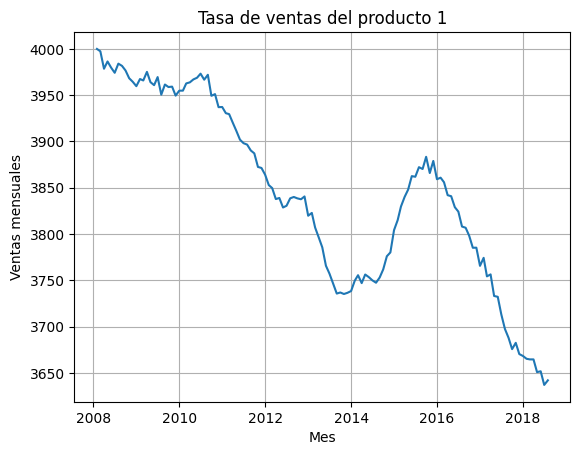

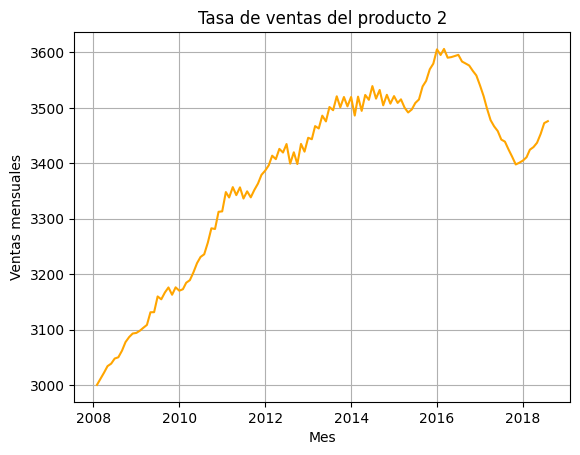

In [13]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos de producto1 y produto2
plt.title("Tasa de ventas del producto 1")
plt.xlabel("Mes")
plt.ylabel("Ventas mensuales")
plt.plot(data[["producto1"]])
plt.grid()
plt.show()

plt.title("Tasa de ventas del producto 2")
plt.xlabel("Mes")
plt.ylabel("Ventas mensuales")
plt.plot(data[["producto2"]], color='orange')
plt.grid()
plt.show()

### 3.4 Encontrando los componentes de las series de tiempo para los productos 1 y 2

En algunas ocasiones puede ser útil empezar nuestro análisis descomponiendo la serie de tiempo en sus componentes: **tendencia**, **estacionalidad** y **componente puramente aleatorio**. Una forma de hacer esto es empleando la función seasonal_decompose.

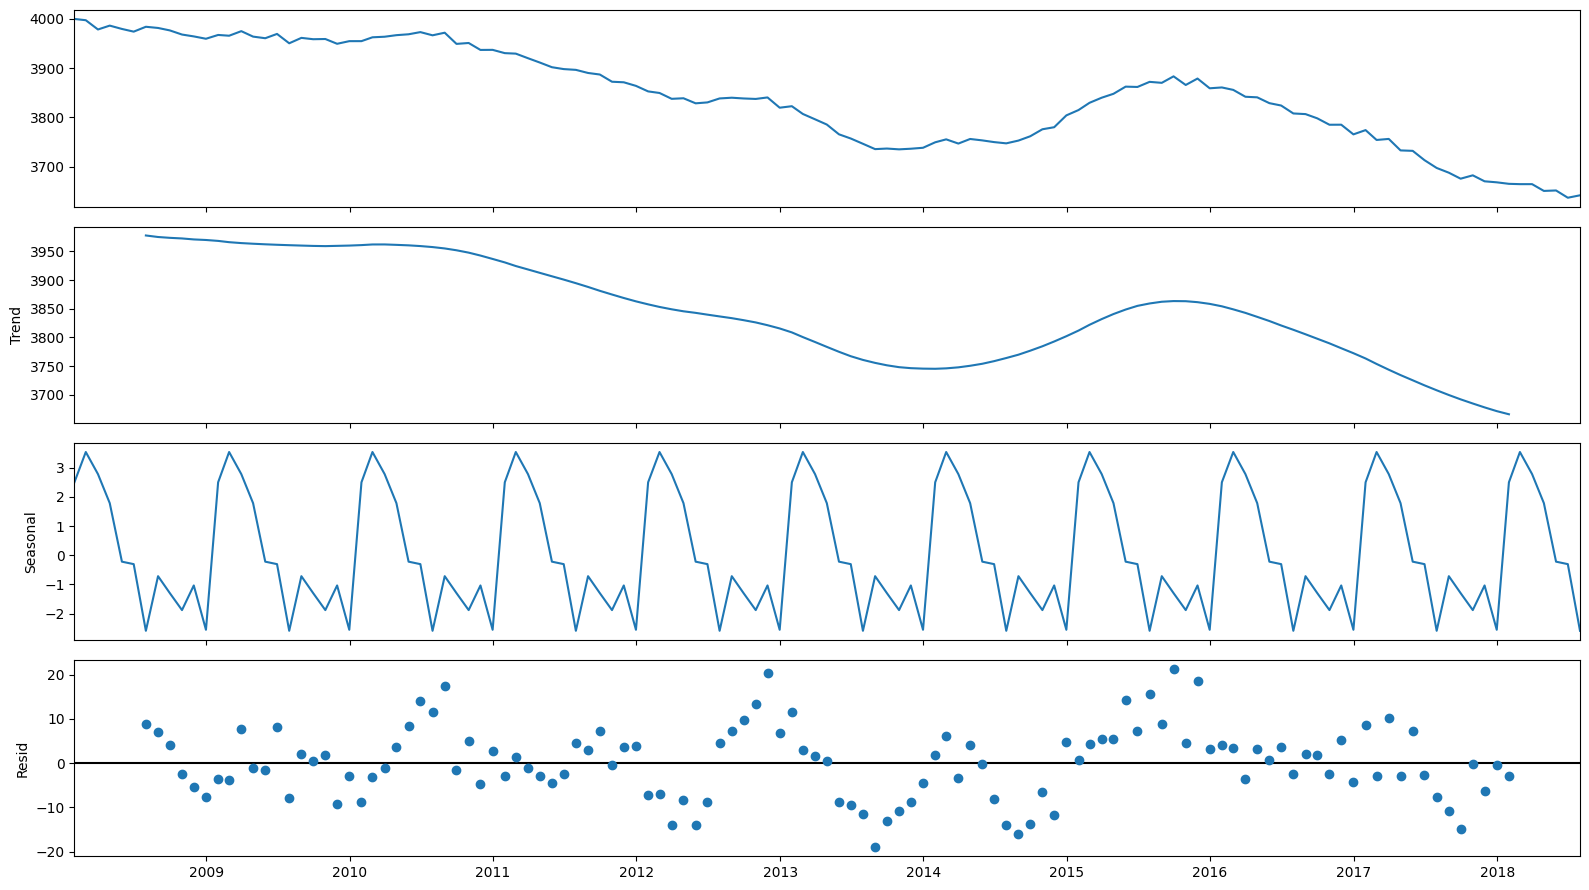

In [14]:
#Componentes serie de tiempo prodcuto1
td_componentes_producto1 = seasonal_decompose(data[["producto1"]],model="additive")
fig = td_componentes_producto1.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

**Podemos observar el componente estacional marcado en la serie de producto1, una tendencia no lineal de los datos y la parte aleatoria.**

Observamos cada componente de la serie de tiempo del producto1

In [15]:
td_componentes_producto1.seasonal

Mes
2008-01-31    2.495315
2008-02-29    3.531537
2008-03-31    2.775396
2008-04-30    1.781834
2008-05-31   -0.220084
                ...   
2018-03-31    2.775396
2018-04-30    1.781834
2018-05-31   -0.220084
2018-06-30   -0.304548
2018-07-31   -2.585303
Name: seasonal, Length: 127, dtype: float64

In [16]:
td_componentes_producto1.trend

Mes
2008-01-31   NaN
2008-02-29   NaN
2008-03-31   NaN
2008-04-30   NaN
2008-05-31   NaN
              ..
2018-03-31   NaN
2018-04-30   NaN
2018-05-31   NaN
2018-06-30   NaN
2018-07-31   NaN
Name: trend, Length: 127, dtype: float64

In [17]:
td_componentes_producto1.resid

Mes
2008-01-31   NaN
2008-02-29   NaN
2008-03-31   NaN
2008-04-30   NaN
2008-05-31   NaN
              ..
2018-03-31   NaN
2018-04-30   NaN
2018-05-31   NaN
2018-06-30   NaN
2018-07-31   NaN
Name: resid, Length: 127, dtype: float64

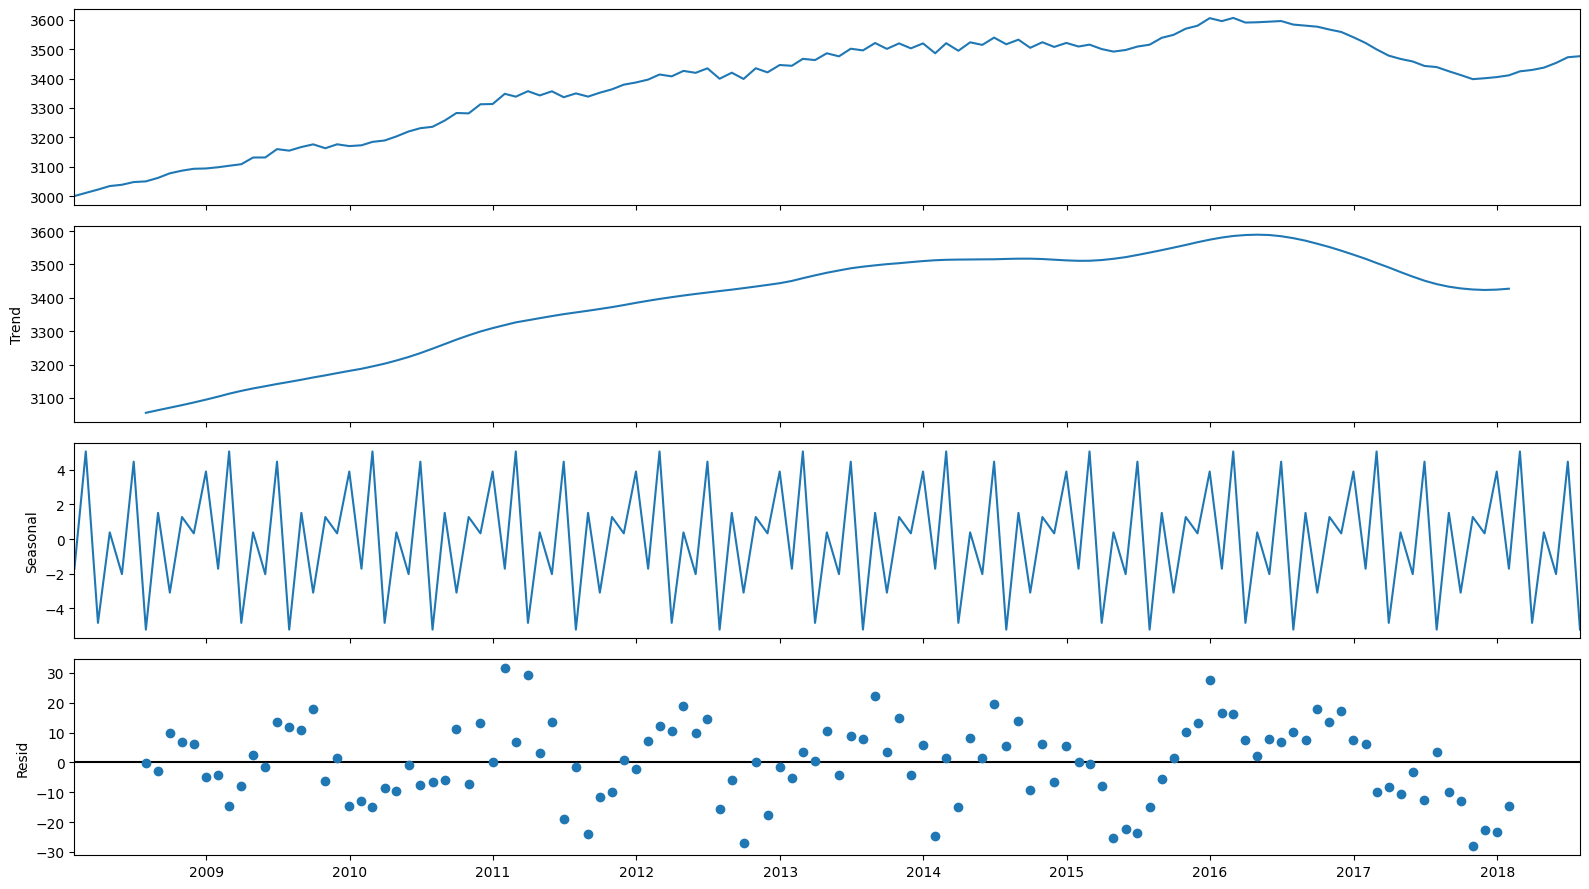

In [18]:
#Componentes serie de tiempo prodcuto2
td_componentes_producto2 = seasonal_decompose(data[["producto2"]],model="additive")
fig = td_componentes_producto2.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

**Podemos observar el componente estacional marcado en la serie producto2, una tendencia no lineal de los datos y la parte aleatoria.**

Observamos cada componente de la serie de tiempo del producto2

In [19]:
td_componentes_producto2.seasonal

Mes
2008-01-31   -1.709341
2008-02-29    5.041275
2008-03-31   -4.827994
2008-04-30    0.382215
2008-05-31   -2.021890
                ...   
2018-03-31   -4.827994
2018-04-30    0.382215
2018-05-31   -2.021890
2018-06-30    4.453935
2018-07-31   -5.214986
Name: seasonal, Length: 127, dtype: float64

In [20]:
td_componentes_producto2.trend

Mes
2008-01-31   NaN
2008-02-29   NaN
2008-03-31   NaN
2008-04-30   NaN
2008-05-31   NaN
              ..
2018-03-31   NaN
2018-04-30   NaN
2018-05-31   NaN
2018-06-30   NaN
2018-07-31   NaN
Name: trend, Length: 127, dtype: float64

In [21]:
td_componentes_producto2.resid

Mes
2008-01-31   NaN
2008-02-29   NaN
2008-03-31   NaN
2008-04-30   NaN
2008-05-31   NaN
              ..
2018-03-31   NaN
2018-04-30   NaN
2018-05-31   NaN
2018-06-30   NaN
2018-07-31   NaN
Name: resid, Length: 127, dtype: float64

Procedemos a realizar una gráfica para comparar ambas series donde vemos el comportamiento de cada producto respecto al otro

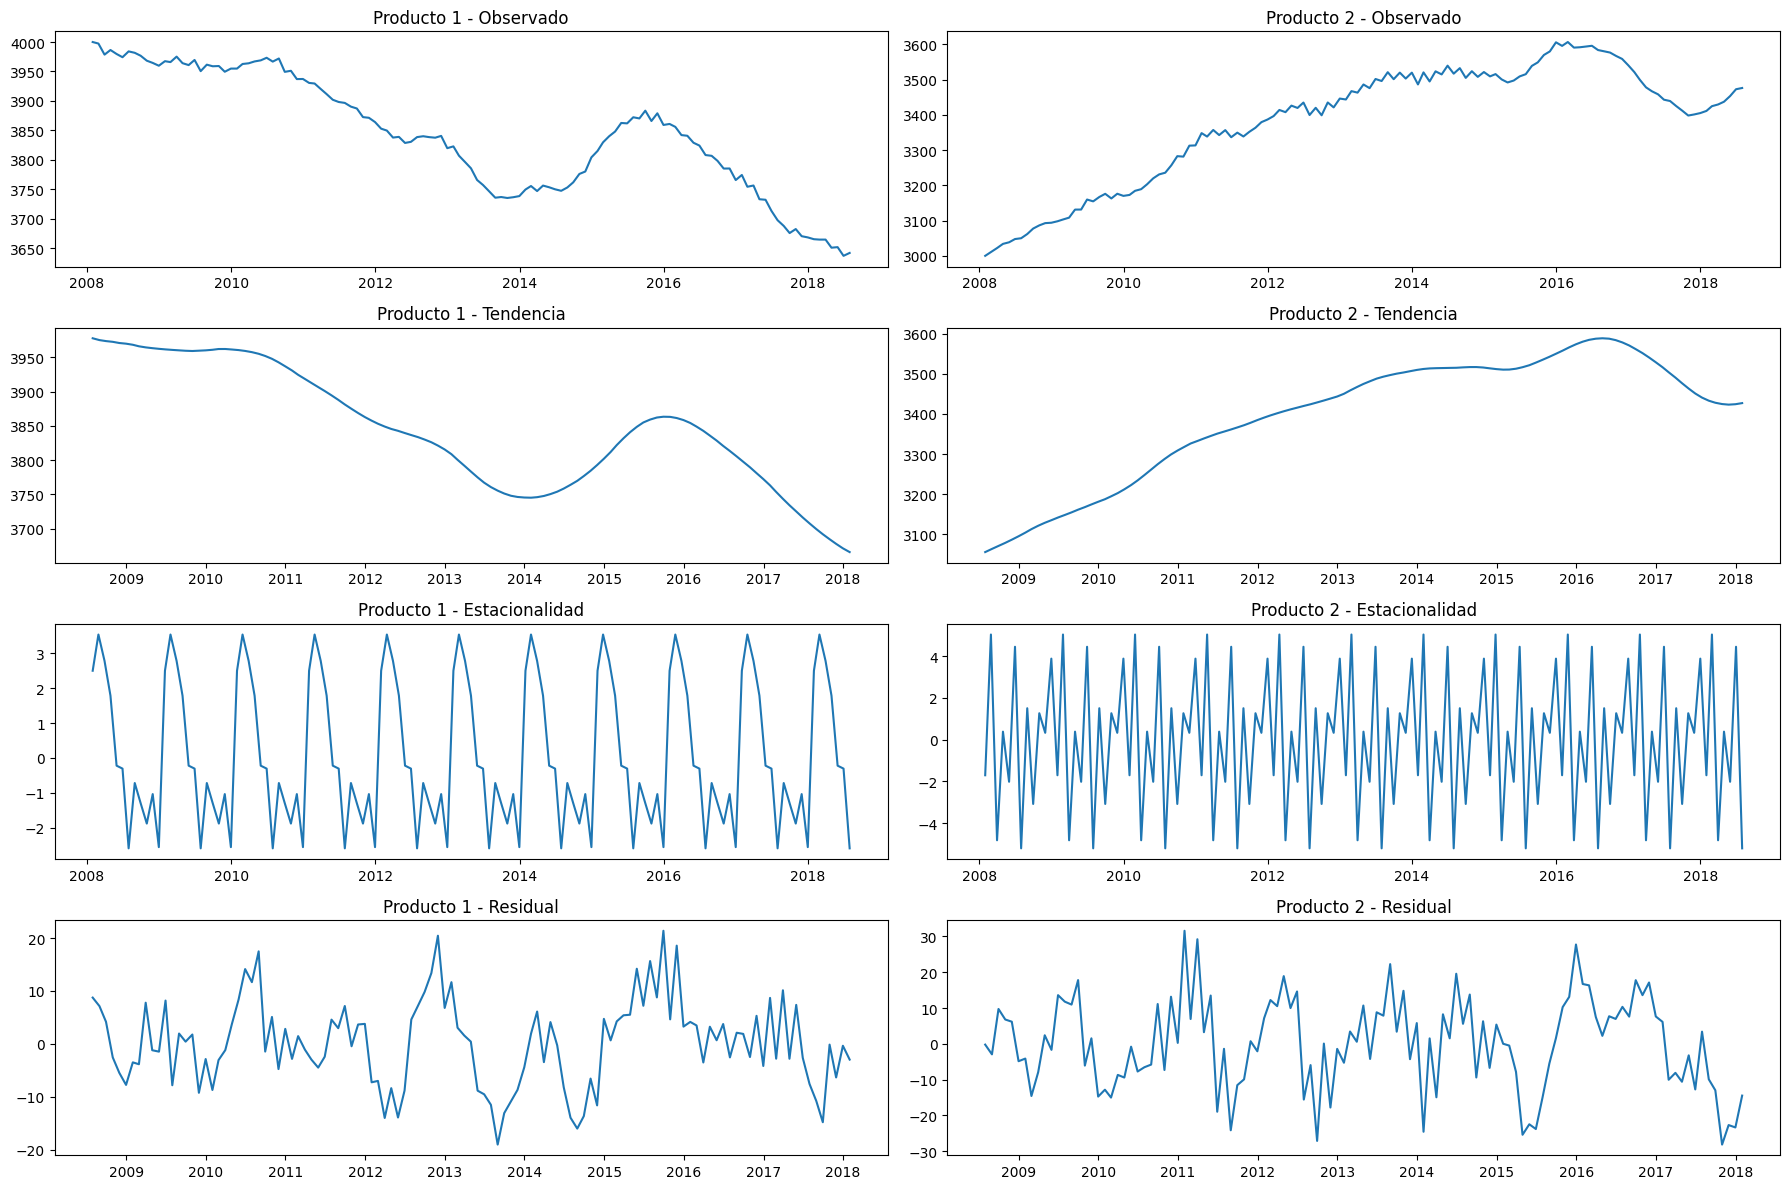

In [22]:
# Crear subplots
fig, axes = plt.subplots(4, 2, figsize=(18, 12))

# Graficar los componentes de producto1
axes[0, 0].plot(td_componentes_producto1.observed)
axes[0, 0].set_title('Producto 1 - Observado')
axes[1, 0].plot(td_componentes_producto1.trend)
axes[1, 0].set_title('Producto 1 - Tendencia')
axes[2, 0].plot(td_componentes_producto1.seasonal)
axes[2, 0].set_title('Producto 1 - Estacionalidad')
axes[3, 0].plot(td_componentes_producto1.resid)
axes[3, 0].set_title('Producto 1 - Residual')

# Graficar los componentes de producto2
axes[0, 1].plot(td_componentes_producto2.observed)
axes[0, 1].set_title('Producto 2 - Observado')
axes[1, 1].plot(td_componentes_producto2.trend)
axes[1, 1].set_title('Producto 2 - Tendencia')
axes[2, 1].plot(td_componentes_producto2.seasonal)
axes[2, 1].set_title('Producto 2 - Estacionalidad')
axes[3, 1].plot(td_componentes_producto2.resid)
axes[3, 1].set_title('Producto 2 - Residual')

# Ajustar el layout
plt.tight_layout()
plt.show()

Aquí notamos que la tendencia de cada producto ha sido inversa es decir: el producto1 tiene una tendencia hacia la baja y el producto2 una tendencia a la alza; pero debemos observar que también a pesar de esto al final ambos prodcutos se encuentran en una ventas similares en cantidad aunque aún vende más el producto1. 

Como observamos una estacionalidad fuerte en ambas, haremos un experimento creando sus 2 versiones sin estacionalidad... para así aplicar los modelos y protocolos de evaluación y comprar cual sería mejor.

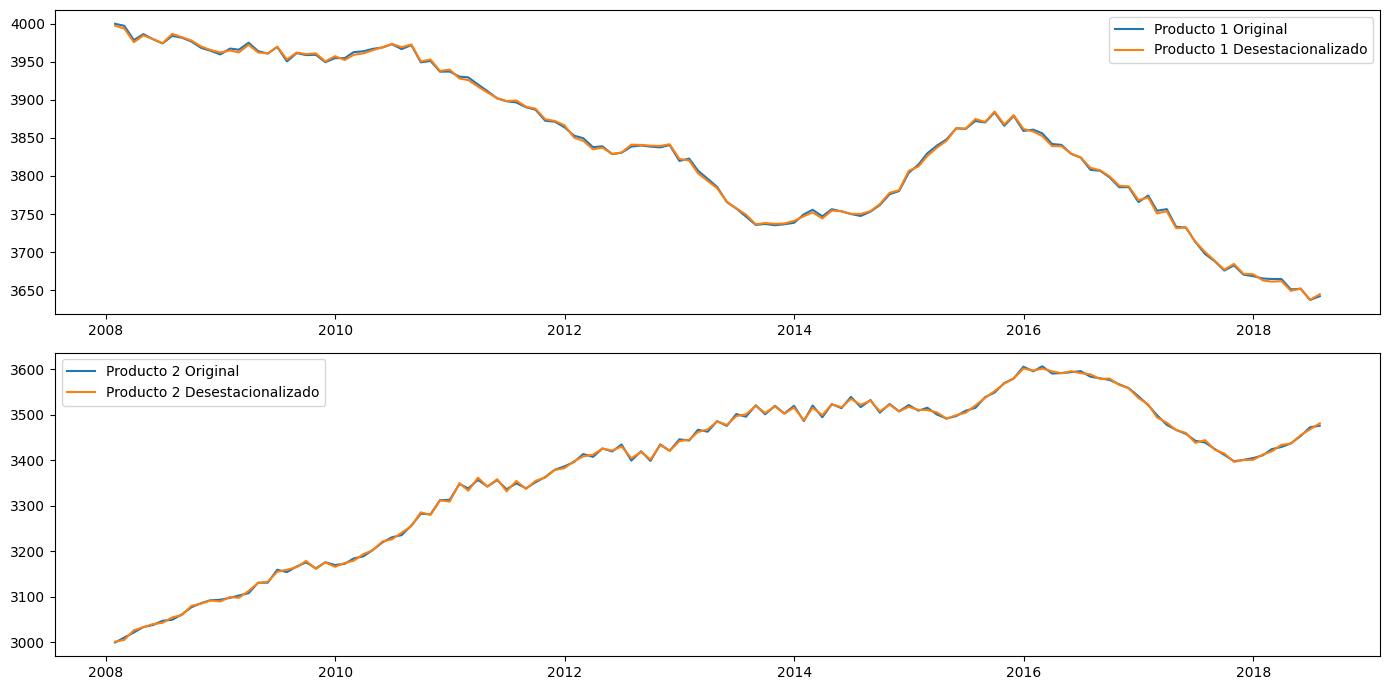

,producto1,producto2,producto1_desestacionalizado,producto2_desestacionalizado
Mes,,,,
2008-01-31,4000.000000,3000.000000,3997.504685,3001.709341
2008-02-29,3997.400893,3010.686220,3993.869356,3005.644945
2008-03-31,3978.605317,3022.018584,3975.829921,3026.846578
2008-04-30,3986.454125,3033.920990,3984.672292,3033.538775
2008-05-31,3979.695678,3038.402098,3979.915762,3040.423988


In [23]:
# Guardar la serie desestacionalizada para producto1
data['producto1_desestacionalizado'] = data['producto1'] - td_componentes_producto1.seasonal

# Guardar la serie desestacionalizada para producto2
data['producto2_desestacionalizado'] = data['producto2'] - td_componentes_producto2.seasonal

# Graficar para ver las series originales y desestacionalizadas
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(data.index, data['producto1'], label='Producto 1 Original')
plt.plot(data.index, data['producto1_desestacionalizado'], label='Producto 1 Desestacionalizado')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(data.index, data['producto2'], label='Producto 2 Original')
plt.plot(data.index, data['producto2_desestacionalizado'], label='Producto 2 Desestacionalizado')
plt.legend()

plt.tight_layout()
plt.show()

# Mostrar las primeras filas del DataFrame para verificar
data.head()


In [42]:
# Exportar el DataFrame 'data' a un archivo CSV
data.to_csv(r'C:\Users\alfa7\OneDrive\Documentos\ICESI\MAESTRIA CIENCIA DE DATOS\2do semestre\Fundamentos de analitica II\Unidad I\Clase 4\data-con-index.csv')


## **4. PROTOCOLOS DE EVALUACION**

### **4.1 Ventana Recursiva**

En un enfoque de ventana recursiva, entrenas el modelo con un conjunto de datos y luego lo usas para predecir un punto en el futuro. Después de obtener la predicción, amplías la ventana para incluir este nuevo punto y repites el proceso.

![alt text](recursive-window.png)

### **4.2 Rolling window**

En una rolling window, mueves la ventana a lo largo del tiempo para generar predicciones, entrenando el modelo solo en los datos más recientes.

![image.png](rolling-window.png)

Dependiendo del modelo a usar se deben hacer algunos ajustes a las funciones para el correcto funcionamiento del protocolo de evaluación, mantedremos la idea de la evaluación con ventanas móviles (rolling window), pero le agregaremos:

- Validación cruzada específica para series de tiempo (TimeSeriesSplit).
- Evaluación walk-forward, que es útil para un enfoque más dinámico y reentrenamiento constante.
- Probaremos estos enfoques y los compararemos.

Se implementan las funciones para evaluar los modelos utilizando ambos protocolos y otra para el cálculo del RMSE.

In [24]:
# Función de evaluación con TimeSeriesSplit (Validación cruzada en series de tiempo)
def cross_validation_evaluation(model_class, data, target_column, init_args=None, fit_args=None, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    test_errors = []
    
    # Asegurarse de que init_args y fit_args sean diccionarios
    if init_args is None:
        init_args = {}
    if fit_args is None:
        fit_args = {}

    for train_index, test_index in tscv.split(data):
        train_data, test_data = data.iloc[train_index], data.iloc[test_index]
        y_train, y_test = train_data[target_column], test_data[target_column]

        # Crear e instanciar el modelo
        model = model_class(y_train, **init_args)
        model_fit = model.fit(**fit_args)
        
        # Hacer predicciones
        y_pred = model_fit.forecast(len(y_test))

        # Calcular el error de predicción
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        test_errors.append(rmse)

    return np.mean(test_errors)

# Evaluación con Rolling Window (ventana móvil)
def rolling_window_evaluation(model_class, data, target_column, window_size=12, steps=1, init_args=None, fit_args=None):
    test_errors = []
    
    # Asegurarse de que init_args y fit_args sean diccionarios
    if init_args is None:
        init_args = {}
    if fit_args is None:
        fit_args = {}

    for i in range(len(data) - window_size - steps):
        train_window = data.iloc[i:i + window_size]
        test_window = data.iloc[i + window_size:i + window_size + steps]

        y_train, y_test = train_window[target_column], test_window[target_column]

        # Crear e instanciar el modelo
        model = model_class(y_train, **init_args)
        model_fit = model.fit(**fit_args)

        # Hacer predicciones
        y_pred = model_fit.forecast(steps)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        test_errors.append(rmse)

    return np.mean(test_errors)

Evaluación Walk-Forward

In [25]:
# Evaluación con Walk-Forward
def walk_forward_evaluation(model_class, data, target_column, steps=1, init_args=None, fit_args=None):
    test_errors = []
    
    if init_args is None:
        init_args = {}
    if fit_args is None:
        fit_args = {}

    for i in range(steps, len(data)):
        train_window = data.iloc[:i]
        test_window = data.iloc[i:i + steps]

        y_train, y_test = train_window[target_column], test_window[target_column]

        # Crear e instanciar el modelo
        model = model_class(y_train, **init_args)
        model_fit = model.fit(**fit_args)

        # Hacer predicciones
        y_pred = model_fit.forecast(steps)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        test_errors.append(rmse)

    return np.mean(test_errors)

## **5. MODELOS**

Implementaremos los siguientes modelos:

- Promedio Móvil (Moving Average)
- Suavización Exponencial (Simple, Holt, Holt-Winters)
- Regresión Polinomial + Dummies Estacionales
- ARIMA

### **5.1 Promedio Móvil**
Este es el modelo más simple, que usa un promedio de los últimos valores para predecir.

In [26]:
class MovingAverageModel:
    def __init__(self, endog, window):
        self.endog = endog
        self.window = window

    def fit(self):
        # No es necesario ajustar nada, solo calculamos el promedio móvil directamente
        self.fittedvalues = self.endog.rolling(window=self.window).mean().dropna()
        return self

    def forecast(self, steps):
        # Usar la última ventana para predecir
        last_window = self.endog.iloc[-self.window:]
        forecast_values = np.full(steps, last_window.mean())
        return pd.Series(forecast_values, index=pd.RangeIndex(start=len(self.endog), stop=len(self.endog) + steps))


### **5.2 Suavización Exponencial (Simple, Holt, Holt-Winters)**
Este modelo incluye diferentes versiones de suavización exponencial:

- Simple: suavización sin tendencia ni estacionalidad.
- Holt: suavización con tendencia.
- Holt-Winters: suavización con tendencia y estacionalidad.

In [27]:
class ExponentialSmoothingModel:
    def __init__(self, endog, trend=None, seasonal=None, seasonal_periods=None):
        self.endog = endog
        self.trend = trend
        self.seasonal = seasonal
        self.seasonal_periods = seasonal_periods

    def fit(self):
        self.model = ExponentialSmoothing(
            self.endog,
            trend=self.trend,
            seasonal=self.seasonal,
            seasonal_periods=self.seasonal_periods
        )
        self.fitted_model = self.model.fit()
        return self.fitted_model

    def forecast(self, steps):
        return self.fitted_model.forecast(steps)


### **5.3 Regresión Polinomial con Dummies Estacionales**

Este modelo ajusta un polinomio de grado n con dummies estacionales para capturar patrones estacionales.

In [28]:
class PolynomialRegressionSeasonalModel:
    def __init__(self, endog, degree, seasonal_periods):
        self.endog = endog
        self.degree = degree
        self.seasonal_periods = seasonal_periods  # Número de periodos estacionales
        self.model = None
        self.poly = PolynomialFeatures(degree=self.degree)
        self.seasonal_dummies = pd.get_dummies(np.arange(self.seasonal_periods) % self.seasonal_periods, drop_first=False)

    def _create_design_matrix(self, y_train, future_steps=None):
        if future_steps is None:
            time_index = np.arange(len(y_train)).reshape(-1, 1)
            seasonality = pd.get_dummies(np.arange(len(y_train)) % self.seasonal_periods, drop_first=False)
        else:
            time_index = np.arange(len(self.endog), len(self.endog) + future_steps).reshape(-1, 1)
            seasonality = pd.get_dummies(np.arange(len(self.endog), len(self.endog) + future_steps) % self.seasonal_periods, drop_first=False)

        poly_features = self.poly.fit_transform(time_index)
        seasonality = seasonality.reindex(columns=self.seasonal_dummies.columns, fill_value=0)

        X = np.hstack([poly_features, seasonality])
        return X

    def fit(self):
        # Crear la matriz de diseño para los datos de entrenamiento
        X_train = self._create_design_matrix(self.endog)

        # Ajustar el modelo de regresión polinomial
        self.model = LinearRegression().fit(X_train, self.endog)
        self.fittedvalues = pd.Series(self.model.predict(X_train), index=self.endog.index)
        return self

    def forecast(self, steps):
        # Crear la matriz de diseño para los pasos futuros
        X_future = self._create_design_matrix(self.endog, future_steps=steps)
        forecast_values = self.model.predict(X_future)
        return pd.Series(forecast_values, index=pd.RangeIndex(start=len(self.endog), stop=len(self.endog) + steps))


### **5.4 ARIMA**

Este modelo se ajusta a datos autoregresivos integrados con medias móviles.

In [29]:
class ARIMAModel:
    def __init__(self, endog, order):
        self.endog = endog
        self.order = order
        self.model = None

    def fit(self):
        # Ajustar el modelo ARIMA
        self.model = ARIMA(self.endog, order=self.order)
        self.fitted_model = self.model.fit()
        return self.fitted_model

    def forecast(self, steps):
        # Hacer las predicciones
        return self.fitted_model.forecast(steps)


## **6. Optimización de Hiperparámetros para cada uno de los modelos usando optimización bayesiana**

### **6.1 Optimización Bayesiana del Promedio Móvil**

Primero ajustamos el tamaño de ventana.

In [30]:
# Diccionario para almacenar los mejores parámetros por serie
mejores_parametros_moving_average = {}

# Optimización bayesiana para Promedio Móvil
def optimize_moving_average(data, series, min_window=2, max_window=20):
    dataset = data[series]

    def objective_function(window_size):
        window_size = int(round(window_size))
        rmse = rolling_window_evaluation(
            model_class=MovingAverageModel,
            data=data,
            target_column=series,
            window_size=12,  # Ventana de entrenamiento
            steps=1,  # Horizonte de predicción
            init_args={'window': window_size}
        )
        return -rmse  # Queremos minimizar el RMSE

    pbounds = {'window_size': (min_window, max_window)}

    optimizer = BayesianOptimization(f=objective_function, pbounds=pbounds, random_state=42)
    optimizer.maximize(init_points=3, n_iter=25)

    best_window = optimizer.max['params']['window_size']
    mejores_parametros_moving_average[series] = {
        'modelo': 'Promedio Móvil',
        'mejor_window': int(round(best_window))
    }
    
    #print(f"Mejor tamaño de ventana para {series}: {int(round(best_window))}")
    print(f"\nMejor tamaño de ventana para {series}: {int(round(best_window))}\n")
    return int(round(best_window))

# Ejecutar optimización bayesiana para Promedio Móvil en las 4 series
for serie in ["producto1", "producto2", "producto1_desestacionalizado", "producto2_desestacionalizado"]:
    best_window = optimize_moving_average(data, serie)

# Mostrar el diccionario con los mejores parámetros al finalizar
print("\nMejores parámetros para Promedio Móvil en todas las series:")
print(mejores_parametros_moving_average)


|   iter    |  target   | window... |
-------------------------------------
| 1         | -26.36    | 8.742     |
| 2         | -32.66    | 19.11     |
| 3         | -32.66    | 15.18     |
| 4         | -17.13    | 5.288     |
| 5         | -9.636    | 2.0       |
| 6         | -9.636    | 2.0       |
| 7         | -9.636    | 2.0       |
| 8         | -9.636    | 2.0       |
| 9         | -9.636    | 2.0       |
| 10        | -9.636    | 2.0       |
| 11        | -9.636    | 2.0       |
| 12        | -9.636    | 2.0       |
| 13        | -9.636    | 2.0       |
| 14        | -9.636    | 2.0       |
| 15        | -9.636    | 2.0       |
| 16        | -9.636    | 2.0       |
| 17        | -9.636    | 2.0       |
| 18        | -9.636    | 2.0       |
| 19        | -9.636    | 2.0       |
| 20        | -9.636    | 2.0       |
| 21        | -9.636    | 2.0       |
| 22        | -9.636    | 2.0       |
| 23        | -9.636    | 2.0       |
| 24        | -9.636    | 2.0       |
| 25        

### **6.2 Optimización Bayesiana del Modelo ETS (Holt-Winters)**

Aquí optimizamos los hiperparámetros de suavización (alpha, beta, gamma) y el tipo de error, tendencia y estacionalidad.

In [31]:
# Diccionario para almacenar los mejores parámetros por serie
mejores_parametros_ETS = {}

# Optimización bayesiana para el Modelo ETS (Holt-Winters)
def optimize_ets_model(data, series, is_producto2=False):
    dataset = data[series]

    def objective_function(alpha, beta, gamma, trend, seasonal, seasonal_periods):
        trend_options = ['add', 'mul', None]
        seasonal_options = ['add', 'mul', None]
        
        # Verificar si hay suficientes datos para el componente estacional
        if len(dataset) < 2 * seasonal_periods:
            seasonal_periods = None
            seasonal = 2  # Ajustamos el componente estacional a None si no hay suficientes ciclos

        model_params = {
            'trend': trend_options[int(round(trend))],
            'seasonal': seasonal_options[int(round(seasonal))] if seasonal != 2 else None,
            'seasonal_periods': int(round(seasonal_periods)) if seasonal_periods else None,
            'initialization_method': 'estimated',
            'use_boxcox': False
        }

        fit_params = {
            'smoothing_level': alpha,
            'smoothing_trend': beta if model_params['trend'] else None,
            'smoothing_seasonal': gamma if model_params['seasonal'] else None
        }

        # Evaluar el modelo con ventana deslizante
        rmse = rolling_window_evaluation(
            model_class=ExponentialSmoothing,
            data=data,
            target_column=series,
            window_size=12,
            steps=1,
            init_args=model_params,
            fit_args=fit_params
        )
        return -rmse  # Minimizar RMSE

    # Establecer los límites de búsqueda
    pbounds = {
        'alpha': (0.01, 0.99),
        'beta': (0.01, 0.99),
        'gamma': (0.01, 0.99),
        'trend': (0, 2),  # 0: 'add', 1: 'mul', 2: None
        'seasonal': (0, 2),  # 0: 'add', 1: 'mul', 2: None
        'seasonal_periods': (3, 6)  # Reducir a periodos más pequeños entre 3 y 6
    }

    optimizer = BayesianOptimization(f=objective_function, pbounds=pbounds, random_state=42)
    optimizer.maximize(init_points=3, n_iter=25)

    # Guardar los mejores parámetros
    best_params = optimizer.max['params']
    mejores_parametros_ETS[series] = {
        'modelo': 'ETS',
        'alpha': best_params['alpha'],
        'beta': best_params['beta'],
        'gamma': best_params['gamma'],
        'trend': int(round(best_params['trend'])),
        'seasonal': int(round(best_params['seasonal'])),
        'seasonal_periods': int(round(best_params['seasonal_periods']))
    }

    print(f"\nMejor resultado para {series}: {optimizer.max}\n")
    return optimizer.max

# Optimizar ETS (Holt-Winters) para las 4 series y guardar los mejores parámetros
for serie in ["producto1", "producto2", "producto1_desestacionalizado", "producto2_desestacionalizado"]:
    is_producto2 = "producto2" in serie
    optimize_ets_model(data, serie, is_producto2=is_producto2)

# Mostrar el diccionario con los mejores parámetros
print("\nMejores parámetros para ETS (Holt-Winters) en todas las series:\n")
print(mejores_parametros_ETS)


|   iter    |  target   |   alpha   |   beta    |   gamma   | seasonal  | season... |   trend   |
-------------------------------------------------------------------------------------------------
| 1         | -8.51     | 0.377     | 0.9417    | 0.7274    | 1.197     | 3.468     | 0.312     |
| 2         | -20.57    | 0.06692   | 0.8589    | 0.5991    | 1.416     | 3.062     | 1.94      |
| 3         | -6.172e+0 | 0.8258    | 0.2181    | 0.1882    | 0.3668    | 3.913     | 1.05      |
| 4         | -8.786    | 0.3498    | 0.9367    | 0.7342    | 1.185     | 3.532     | 0.3604    |
| 5         | -15.23    | 0.01      | 0.99      | 0.99      | 2.0       | 3.0       | 0.8637    |
| 6         | -12.99    | 0.01      | 0.99      | 0.99      | 2.0       | 4.658     | 0.0       |
| 7         | -32.62    | 0.01      | 0.99      | 0.99      | 2.0       | 6.0       | 2.0       |
| 8         | -10.55    | 0.99      | 0.99      | 0.99      | 2.0       | 6.0       | 0.4012    |
| 9         | -32.62

C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


| 18        | -20.11    | 0.1085    | 0.06835   | 0.2835    | 1.121     | 3.0       | 0.9649    |
| 19        | -91.42    | 0.8802    | 0.7509    | 0.99      | 0.6733    | 3.0       | 1.274     |
| 20        | -19.05    | 0.01      | 0.01      | 0.99      | 2.0       | 3.755     | 0.1953    |
| 21        | -14.39    | 0.99      | 0.01      | 0.99      | 1.057     | 4.113     | 0.1171    |
| 22        | -12.41    | 0.9413    | 0.3711    | 0.01556   | 2.0       | 3.875     | 0.1782    |
| 23        | -12.8     | 0.99      | 0.01      | 0.99      | 1.849     | 3.0       | 0.3627    |
| 24        | -14.54    | 0.99      | 0.01      | 0.01      | 0.6907    | 3.03      | 0.0       |
| 25        | -18.74    | 0.1651    | 0.01      | 0.99      | 0.05598   | 3.277     | 0.2771    |
| 26        | -18.55    | 0.1525    | 0.99      | 0.01      | 0.0       | 3.0       | 0.7097    |
| 27        | -18.9     | 0.99      | 0.99      | 0.01      | 1.705     | 3.0       | 1.104     |
| 28        | -26.27

### **6.3 Optimización Bayesiana de Regresión Polinomial con Dummies Estacionales**

Aquí optimizamos el grado del polinomio.

In [32]:
# Diccionario para almacenar los mejores parámetros por serie
mejores_parametros_polynomial = {}

# Optimización bayesiana para Regresión Polinomial
def optimize_polynomial_regression(data, series):
    dataset = data[series]

    def objective_function(degree):
        rmse = rolling_window_evaluation(
            model_class=PolynomialRegressionSeasonalModel,
            data=data,
            target_column=series,
            window_size=12,
            steps=1,
            init_args={'degree': int(round(degree)), 'seasonal_periods': 12}
        )
        return -rmse  # Minimizar RMSE

    pbounds = {
        'degree': (1, 10)  # Probar polinomios de grado 1 a 10
    }

    optimizer = BayesianOptimization(f=objective_function, pbounds=pbounds, random_state=42)
    optimizer.maximize(init_points=3, n_iter=25)

    # Guardar los mejores parámetros
    best_params = optimizer.max['params']
    mejores_parametros_polynomial[series] = {
        'modelo': 'PolynomialRegression',
        'degree': int(round(best_params['degree'])),
        'seasonal_periods': 12  # Ya que siempre estamos usando 12 periodos estacionales
    }

    print(f"\nMejor resultado para {series}: {optimizer.max}\n")
    return optimizer.max

# Optimizar Regresión Polinomial para las 4 series y guardar los mejores parámetros
for serie in ["producto1", "producto2", "producto1_desestacionalizado", "producto2_desestacionalizado"]:
    optimize_polynomial_regression(data, serie)

# Mostrar el diccionario con los mejores parámetros
print("\nMejores parámetros para Regresión Polinomial en todas las series:\n")
print(mejores_parametros_polynomial)


|   iter    |  target   |  degree   |
-------------------------------------
| 1         | -10.78    | 4.371     |
| 2         | -372.8    | 9.556     |
| 3         | -75.53    | 7.588     |
| 4         | -10.78    | 4.448     |
| 5         | -11.92    | 1.0       |
| 6         | -10.78    | 2.456     |
| 7         | -22.43    | 6.2       |
| 8         | -10.78    | 1.691     |
| 9         | -9.804    | 3.321     |
| 10        | -15.1     | 5.361     |
| 11        | -10.78    | 3.749     |
| 12        | -9.804    | 2.892     |
| 13        | -11.92    | 1.327     |
| 14        | -10.78    | 2.057     |
| 15        | -15.1     | 4.868     |
| 16        | -9.804    | 3.106     |
| 17        | -10.78    | 3.505     |
| 18        | -10.78    | 4.03      |
| 19        | -9.804    | 2.709     |
| 20        | -9.804    | 3.218     |
| 21        | -9.804    | 2.798     |
| 22        | -9.804    | 2.997     |
| 23        | -9.804    | 3.228     |
| 24        | -9.804    | 2.798     |
| 25        

### **6.4 Optimización Bayesiana de ARIMA**

Vamos a optimizar los parámetros p, d, y q del modelo ARIMA.

In [33]:
# Diccionario para almacenar los mejores parámetros de ARIMA de cada serie
mejores_parametros_ARIMA = {}

# Optimización bayesiana para ARIMA
def optimize_arima_model(data, series):
    dataset = data[series]

    def objective_function(p, d, q):
        try:
            order = (int(round(p)), int(round(d)), int(round(q)))
            rmse = rolling_window_evaluation(
                model_class=ARIMAModel,
                data=data,
                target_column=series,
                window_size=12,
                steps=1,
                init_args={'order': order}
            )
            return -rmse  # Minimizar RMSE
        except Exception as e:
            print(f"\nError con el modelo ARIMA con orden {order}: {e}\n")
            return 1e9  # Penalización alta en caso de error

    pbounds = {
        'p': (0, 2),  # Ajustamos el rango de p
        'd': (0, 1),  # Ajustamos el rango de d
        'q': (0, 2)   # Ajustamos el rango de q
    }

    optimizer = BayesianOptimization(f=objective_function, pbounds=pbounds, random_state=42)
    optimizer.maximize(init_points=3, n_iter=25)

    best_params = optimizer.max['params']
    # Guardar los mejores parámetros en el diccionario global
    mejores_parametros_ARIMA[series] = {
        'p': int(round(best_params['p'])),
        'd': int(round(best_params['d'])),
        'q': int(round(best_params['q']))
    }

    print(f"\nMejores parámetros ARIMA para {series}: {mejores_parametros_ARIMA[series]}\n")
    return optimizer.max

# Optimizar ARIMA para las 4 series
for serie in ["producto1", "producto2", "producto1_desestacionalizado", "producto2_desestacionalizado"]:
    optimize_arima_model(data, serie)

# Mostrar el diccionario con los parámetros optimizados para ARIMA
print("\nMejores parámetros para ARIMA en todas las series:\n")
print(mejores_parametros_ARIMA)


|   iter    |  target   |     d     |     p     |     q     |
-------------------------------------------------------------
| 1         | -9.776    | 0.3745    | 1.901     | 1.464     |
| 2         | -7.909    | 0.5987    | 0.312     | 0.312     |
| 3         | -9.776    | 0.05808   | 1.732     | 1.202     |
| 4         | -8.362    | 1.0       | 0.0       | 1.203     |
| 5         | -32.66    | 0.0       | 0.0       | 0.0       |
| 6         | -7.909    | 0.6001    | 0.3123    | 0.3069    |
| 7         | -7.995    | 1.0       | 0.8074    | 0.5329    |
| 8         | -7.995    | 0.6173    | 0.8261    | 1.485     |
| 9         | -16.18    | 0.3434    | 0.04168   | 2.0       |
| 10        | -7.909    | 1.0       | 0.0       | 0.4673    |
| 11        | -6.457    | 0.784     | 1.872     | 0.3444    |
| 12        | -9.871    | 0.05441   | 2.0       | 0.0       |
| 13        | -6.622    | 1.0       | 1.537     | 1.023     |
| 14        | -6.928    | 1.0       | 1.423     | 2.0       |
| 15    

## **7. Evaluar el rendimiento de cada modelo optimizado (utilizando RMSE) en tus protocolos de evaluación.**

In [34]:
# Verificar que todos los parámetros estén presentes para cada serie
for serie in ["producto1", "producto2", "producto1_desestacionalizado", "producto2_desestacionalizado"]:
    if serie not in mejores_parametros_moving_average:
        print(f"Error: No se encontraron parámetros optimizados de Promedio Móvil para {serie}")
    if serie not in mejores_parametros_ETS:
        print(f"Error: No se encontraron parámetros optimizados de ETS para {serie}")
    if serie not in mejores_parametros_polynomial:
        print(f"Error: No se encontraron parámetros optimizados de Regresión Polinomial para {serie}")
    if serie not in mejores_parametros_ARIMA:
        print(f"Error: No se encontraron parámetros optimizados de ARIMA para {serie}")

In [35]:
# Evaluación de cada modelo utilizando RMSE

# Evaluar Promedio Móvil
def evaluar_promedio_movil(data, series, protocolo='rolling'):
    # Acceder al parámetro correcto desde el diccionario
    mejor_window = int(mejores_parametros_moving_average[series]['mejor_window'])
    print(f"\nEvaluando Promedio Móvil para {series} con window={mejor_window}\n")
    
    rmse = None
    if protocolo == 'rolling':
        rmse = rolling_window_evaluation(
            model_class=MovingAverageModel,
            data=data,
            target_column=series,
            window_size=12,
            steps=1,
            init_args={'window': mejor_window}
        )
    elif protocolo == 'cross_validation':
        rmse = cross_validation_evaluation(
            model_class=MovingAverageModel,
            data=data,
            target_column=series,
            init_args={'window': mejor_window},
            n_splits=5
        )
    elif protocolo == 'walk_forward':
        rmse = walk_forward_evaluation(
            model_class=MovingAverageModel,
            data=data,
            target_column=series,
            steps=1,
            init_args={'window': mejor_window}
        )
    
    print(f"\nRMSE para Promedio Móvil en {series}: {rmse}\n")
    return rmse

# Evaluar ETS (Holt-Winters)
def evaluar_ets_model(data, series, protocolo='rolling'):
    params = mejores_parametros_ETS[series]
    print(f"\nEvaluando ETS para {series} con params={params}\n")
    
    # Asegurarnos de que 'trend' y 'seasonal' sean valores válidos para el modelo
    trend = params['trend']
    seasonal = params['seasonal']
    
    # Mapear los valores que pueden estar guardados en params a los valores aceptados por el modelo
    trend_str = None
    seasonal_str = None
    
    if trend == 'add' or trend == 'mul':
        trend_str = trend
    elif trend is None:
        trend_str = None  # Asegurarse de que sea None si está vacío
    
    if seasonal == 'add' or seasonal == 'mul':
        seasonal_str = seasonal
    elif seasonal is None:
        seasonal_str = None  # Asegurarse de que sea None si está vacío

    model_params = {
        'trend': trend_str,  # Usar cadena de texto o None
        'seasonal': seasonal_str,  # Usar cadena de texto o None
        'seasonal_periods': params['seasonal_periods'],
        'initialization_method': 'estimated'
    }
    
    fit_params = {
        'smoothing_level': params['alpha'],
        'smoothing_trend': params['beta'] if trend_str else None,
        'smoothing_seasonal': params['gamma'] if seasonal_str else None
    }
    
    rmse = None
    if protocolo == 'rolling':
        rmse = rolling_window_evaluation(
            model_class=ExponentialSmoothing,
            data=data,
            target_column=series,
            window_size=12,
            steps=1,
            init_args=model_params,
            fit_args=fit_params
        )
    elif protocolo == 'cross_validation':
        rmse = cross_validation_evaluation(
            model_class=ExponentialSmoothing,
            data=data,
            target_column=series,
            init_args=model_params,
            fit_args=fit_params,
            n_splits=5
        )
    elif protocolo == 'walk_forward':
        rmse = walk_forward_evaluation(
            model_class=ExponentialSmoothing,
            data=data,
            target_column=series,
            steps=1,
            init_args=model_params,
            fit_args=fit_params
        )
    
    print(f"\nRMSE para ETS en {series}: {rmse}\n")
    return rmse

# Evaluar Regresión Polinomial
def evaluar_polynomial_regression(data, series, protocolo='rolling'):
    # Acceder al grado óptimo desde el diccionario
    mejor_degree = mejores_parametros_polynomial[series]['degree']
    print(f"\nEvaluando Regresión Polinomial para {series} con degree={mejor_degree}\n")
    
    rmse = None
    if protocolo == 'rolling':
        rmse = rolling_window_evaluation(
            model_class=PolynomialRegressionSeasonalModel,
            data=data,
            target_column=series,
            window_size=12,
            steps=1,
            init_args={'degree': mejor_degree, 'seasonal_periods': 12}
        )
    elif protocolo == 'cross_validation':
        rmse = cross_validation_evaluation(
            model_class=PolynomialRegressionSeasonalModel,
            data=data,
            target_column=series,
            init_args={'degree': mejor_degree, 'seasonal_periods': 12},
            n_splits=5
        )
    elif protocolo == 'walk_forward':
        rmse = walk_forward_evaluation(
            model_class=PolynomialRegressionSeasonalModel,
            data=data,
            target_column=series,
            steps=1,
            init_args={'degree': mejor_degree, 'seasonal_periods': 12}
        )
    
    print(f"\nRMSE para Regresión Polinomial en {series}: {rmse}\n")
    return rmse

# Evaluar ARIMA con manejo de errores
def evaluar_arima_model(data, series, protocolo='rolling'):
    params = mejores_parametros_ARIMA[series]
    print(f"\nEvaluando ARIMA para {series} con params={params}\n")
    
    rmse = None
    try:
        if protocolo == 'rolling':
            rmse = rolling_window_evaluation(
                model_class=ARIMAModel,
                data=data,
                target_column=series,
                window_size=12,
                steps=1,
                init_args={'order': (params['p'], params['d'], params['q'])}
            )
        elif protocolo == 'cross_validation':
            rmse = cross_validation_evaluation(
                model_class=ARIMAModel,
                data=data,
                target_column=series,
                init_args={'order': (params['p'], params['d'], params['q'])},
                n_splits=5
            )
        elif protocolo == 'walk_forward':
            rmse = walk_forward_evaluation(
                model_class=ARIMAModel,
                data=data,
                target_column=series,
                steps=1,
                init_args={'order': (params['p'], params['d'], params['q'])}
            )
    except LinAlgError as e:
        print(f"Error de descomposición LU con ARIMA para {series}: {e}")
        rmse = 1e9  # Penalización alta si ocurre error
    except ValueError as e:
        print(f"Error en ARIMA para {series}: {e}")
        rmse = 1e9  # Penalización alta si ocurre error
    
    print(f"\nRMSE para ARIMA en {series}: {rmse}\n")
    return rmse

# Evaluar los modelos en las 4 series
for serie in ["producto1", "producto2", "producto1_desestacionalizado", "producto2_desestacionalizado"]:
    print(f"\nEvaluación para {serie}:\n")
    
    print("\n### Evaluando Promedio Móvil ###\n")
    evaluar_promedio_movil(data, serie, protocolo='rolling')
    
    print("\n### Evaluando ETS (Holt-Winters) ###\n")
    evaluar_ets_model(data, serie, protocolo='rolling')
    
    print("\n### Evaluando Regresión Polinomial ###\n")
    evaluar_polynomial_regression(data, serie, protocolo='rolling')
    
    print("\n### Evaluando ARIMA ###\n")
    evaluar_arima_model(data, serie, protocolo='rolling')



Evaluación para producto1:


### Evaluando Promedio Móvil ###


Evaluando Promedio Móvil para producto1 con window=2


RMSE para Promedio Móvil en producto1: 9.636092923923371


### Evaluando ETS (Holt-Winters) ###


Evaluando ETS para producto1 con params={'modelo': 'ETS', 'alpha': 0.6603112807328387, 'beta': 0.3824094817683244, 'gamma': 0.8416205282184501, 'trend': 1, 'seasonal': 2, 'seasonal_periods': 4}


RMSE para ETS en producto1: 9.71960306462128


### Evaluando Regresión Polinomial ###


Evaluando Regresión Polinomial para producto1 con degree=3


RMSE para Regresión Polinomial en producto1: 9.80407073687296


### Evaluando ARIMA ###


Evaluando ARIMA para producto1 con params={'p': 2, 'd': 1, 'q': 0}


RMSE para ARIMA en producto1: 6.457048242489758


Evaluación para producto2:


### Evaluando Promedio Móvil ###


Evaluando Promedio Móvil para producto2 con window=2


RMSE para Promedio Móvil en producto2: 13.656940225054118


### Evaluando ETS (Holt-Winters) ###


Evaluando 

## **8. Comparar los resultados y seleccionar el mejor modelo para tus series de tiempo.**

In [36]:
# Diccionario para almacenar los resultados de RMSE por serie y modelo
resultados_rmse = {
    'producto1': {},
    'producto2': {},
    'producto1_desestacionalizado': {},
    'producto2_desestacionalizado': {}
}

# Función para recopilar los RMSE de cada modelo
def recopilar_resultados_rmse(data, series, protocolo='rolling'):
    print(f"\n### Evaluación para {series} ###\n")

    # Evaluar Promedio Móvil
    print("\nEvaluando Promedio Móvil\n")
    rmse_moving_average = evaluar_promedio_movil(data, series, protocolo=protocolo)
    resultados_rmse[series]['Promedio Móvil'] = rmse_moving_average
    
    # Evaluar ETS (Holt-Winters)
    print("\nEvaluando ETS (Holt-Winters)\n")
    rmse_ets = evaluar_ets_model(data, series, protocolo=protocolo)
    resultados_rmse[series]['ETS'] = rmse_ets
    
    # Evaluar Regresión Polinomial
    print("\nEvaluando Regresión Polinomial\n")
    rmse_polynomial = evaluar_polynomial_regression(data, series, protocolo=protocolo)
    resultados_rmse[series]['Regresión Polinomial'] = rmse_polynomial
    
    # Evaluar ARIMA
    print("\nEvaluando ARIMA\n")
    rmse_arima = evaluar_arima_model(data, series, protocolo=protocolo)
    resultados_rmse[series]['ARIMA'] = rmse_arima

# Evaluar los modelos para las 4 series
for serie in ["producto1", "producto2", "producto1_desestacionalizado", "producto2_desestacionalizado"]:
    recopilar_resultados_rmse(data, serie, protocolo='rolling')

# Mostrar los resultados de RMSE para cada serie
print("\n### Resultados de RMSE por serie y modelo ###\n")
for serie, modelos in resultados_rmse.items():
    print(f"Serie: {serie}")
    for modelo, rmse in modelos.items():
        print(f"  {modelo}: RMSE = {rmse}")
    print("\n")

# Seleccionar el mejor modelo para cada serie
mejores_modelos = {}

for serie, modelos in resultados_rmse.items():
    mejor_modelo = min(modelos, key=modelos.get)
    mejores_modelos[serie] = mejor_modelo

print("\n### Mejor modelo para cada serie ###\n")
for serie, mejor_modelo in mejores_modelos.items():
    print(f"Serie: {serie} - Mejor modelo: {mejor_modelo}")



### Evaluación para producto1 ###


Evaluando Promedio Móvil


Evaluando Promedio Móvil para producto1 con window=2


RMSE para Promedio Móvil en producto1: 9.636092923923371


Evaluando ETS (Holt-Winters)


Evaluando ETS para producto1 con params={'modelo': 'ETS', 'alpha': 0.6603112807328387, 'beta': 0.3824094817683244, 'gamma': 0.8416205282184501, 'trend': 1, 'seasonal': 2, 'seasonal_periods': 4}


RMSE para ETS en producto1: 9.71960306462128


Evaluando Regresión Polinomial


Evaluando Regresión Polinomial para producto1 con degree=3


RMSE para Regresión Polinomial en producto1: 9.80407073687296


Evaluando ARIMA


Evaluando ARIMA para producto1 con params={'p': 2, 'd': 1, 'q': 0}


RMSE para ARIMA en producto1: 6.457048242489758


### Evaluación para producto2 ###


Evaluando Promedio Móvil


Evaluando Promedio Móvil para producto2 con window=2


RMSE para Promedio Móvil en producto2: 13.656940225054118


Evaluando ETS (Holt-Winters)


Evaluando ETS para producto2 con params={'mo

## **9. Análisis de residuales: Asegurarte de que los residuos sean adecuados mediante pruebas de normalidad y autocorrelación.**

Iniciamos creando el modelo para cada serie con el mejor RMSE obtenido para escoger modelo y parámetros.

### **9.1 PRODUCTO1**

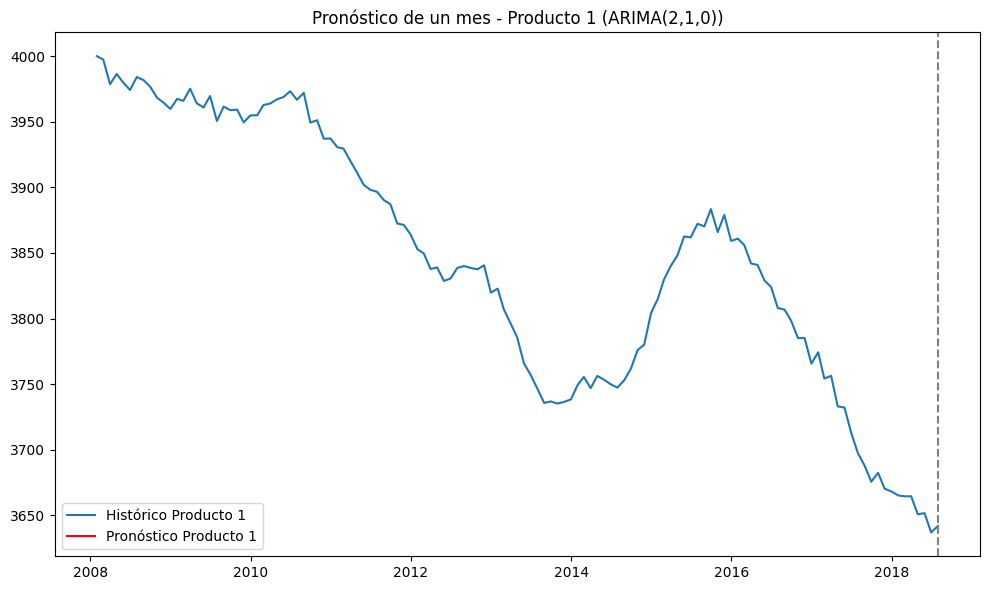

2018-07-31    3637.247894
Freq: M, dtype: float64


In [46]:
# Seleccionar la serie temporal del producto 1
producto1 = data['producto1']

# Dividir los datos en entrenamiento y prueba (último mes como prueba)
train_size = len(producto1) - 1
train_producto1 = producto1[:train_size]
test_producto1 = producto1[train_size:]

# Construcción del modelo ARIMA para producto1 con los parámetros indicados (p=2, d=1, q=0)
model_arima_p1_custom = ARIMA(train_producto1, order=(2, 1, 0))

# Ajustar el modelo
model_fit_p1_custom = model_arima_p1_custom.fit()

# Hacer el pronóstico para el próximo mes
forecast_p1_custom = model_fit_p1_custom.forecast(steps=1)

# Graficar el pronóstico
plt.figure(figsize=(10, 6))
plt.plot(producto1, label='Histórico Producto 1')
plt.axvline(producto1.index[-1], color='gray', linestyle='--')
plt.plot(forecast_p1_custom.index, forecast_p1_custom, label='Pronóstico Producto 1', color='red')
plt.title('Pronóstico de un mes - Producto 1 (ARIMA(2,1,0))')
plt.legend()

plt.tight_layout()
plt.show()

# Mostrar el valor del pronóstico
print(forecast_p1_custom)


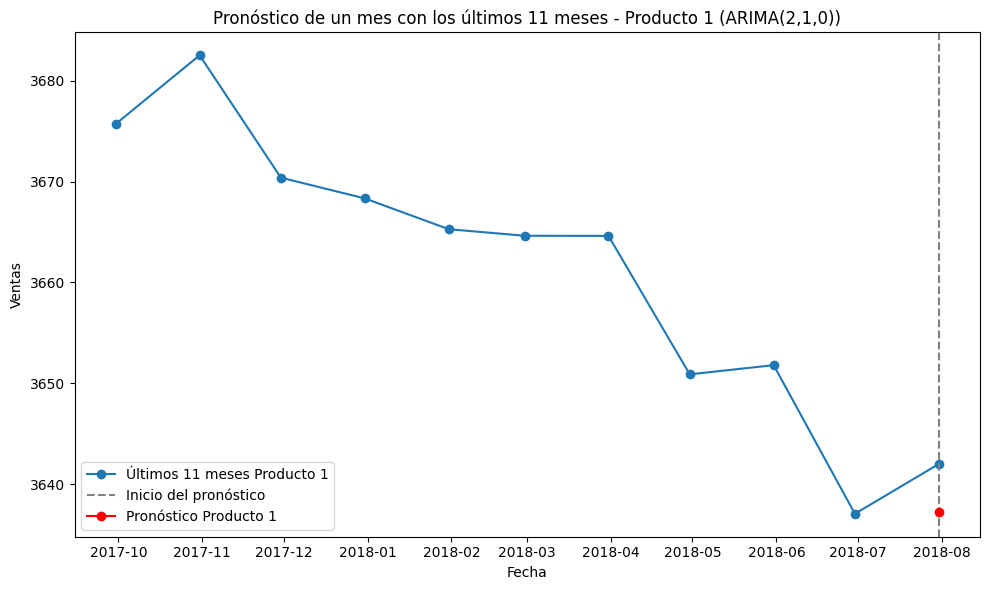

In [47]:
# Graficar los últimos 11 meses de datos históricos y el pronóstico
plt.figure(figsize=(10, 6))

# Graficar los últimos 11 meses del histórico del Producto 1
plt.plot(producto1[-11:], label='Últimos 11 meses Producto 1', marker='o')
plt.axvline(producto1.index[-1], color='gray', linestyle='--', label='Inicio del pronóstico')

# Agregar el pronóstico
plt.plot(forecast_p1_custom.index, forecast_p1_custom, label='Pronóstico Producto 1', color='red', marker='o')

# Etiquetas y título
plt.title('Pronóstico de un mes con los últimos 11 meses - Producto 1 (ARIMA(2,1,0))')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()

# Mostrar la gráfica
plt.tight_layout()
plt.show()


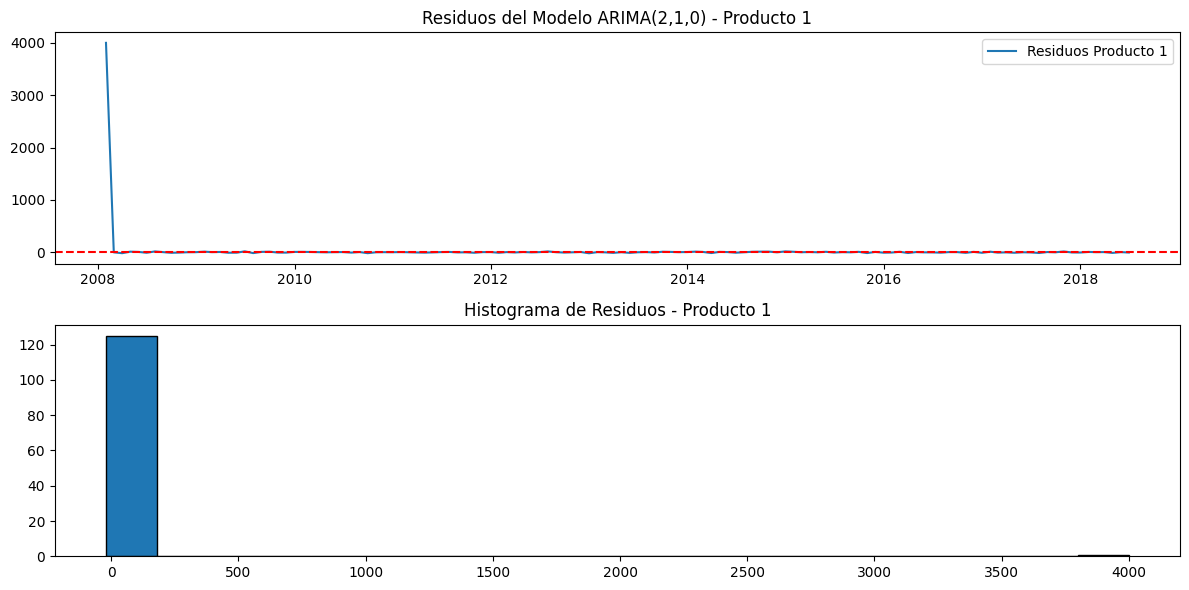

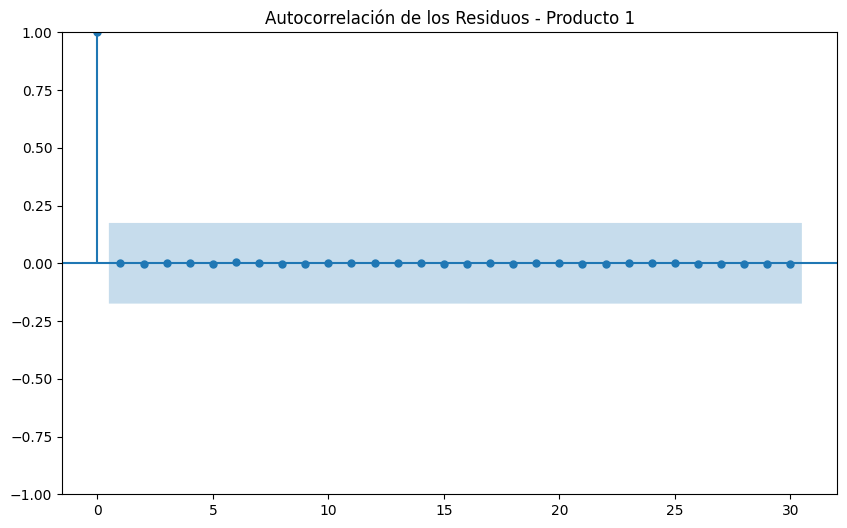

Prueba Shapiro-Wilk: Estadístico=0.07382351160049438, p-valor=1.2359574868011092e-24
Los residuos NO siguen una distribución normal.
Resultados de la prueba de Ljung-Box:
     lb_stat  lb_pvalue
10  0.008291        1.0


In [48]:
# Realizar el análisis de residuos
residuals_p1 = model_fit_p1_custom.resid

# 1. Graficar los residuos
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(residuals_p1, label='Residuos Producto 1')
plt.axhline(0, linestyle='--', color='red')
plt.title('Residuos del Modelo ARIMA(2,1,0) - Producto 1')
plt.legend()

# 2. Histograma de los residuos
plt.subplot(2, 1, 2)
plt.hist(residuals_p1, bins=20, edgecolor='black')
plt.title('Histograma de Residuos - Producto 1')

plt.tight_layout()
plt.show()

# 3. Autocorrelación de los residuos
fig, ax = plt.subplots(figsize=(10, 6))
sm.graphics.tsa.plot_acf(residuals_p1, lags=30, ax=ax)
plt.title('Autocorrelación de los Residuos - Producto 1')
plt.show()

# 4. Prueba de normalidad Shapiro-Wilk
stat, p_value = shapiro(residuals_p1)
print(f'Prueba Shapiro-Wilk: Estadístico={stat}, p-valor={p_value}')
if p_value > 0.05:
    print('Los residuos parecen seguir una distribución normal.')
else:
    print('Los residuos NO siguen una distribución normal.')

# 5. Prueba de autocorrelación Ljung-Box
ljung_box_result = acorr_ljungbox(residuals_p1, lags=[10], return_df=True)
print(f'Resultados de la prueba de Ljung-Box:\n{ljung_box_result}')


Interpretación:

- lb_stat: Es el valor calculado de la prueba. No es directamente interpretado, pero en general, valores pequeños indican poca evidencia de autocorrelación.

- lb_pvalue: Este es el valor clave para hacer la interpretación. En tu caso, tienes un p-valor de 1.0, lo que significa que no hay evidencia significativa de autocorrelación en los residuos.

Conclusión:
- Dado que el p-valor es muy alto (1.0), podemos concluir que no hay autocorrelación significativa en los residuos. Esto significa que los residuos del modelo se comportan como ruido blanco, lo cual es un buen indicador de que el modelo ARIMA está bien ajustado y no tiene dependencias o patrones no capturados en los residuos.

En resumen, el modelo parece estar ajustado correctamente desde el punto de vista de la autocorrelación de los residuos.

### **9.2 PRODUCTO1 DESESTACIONALIZADO**

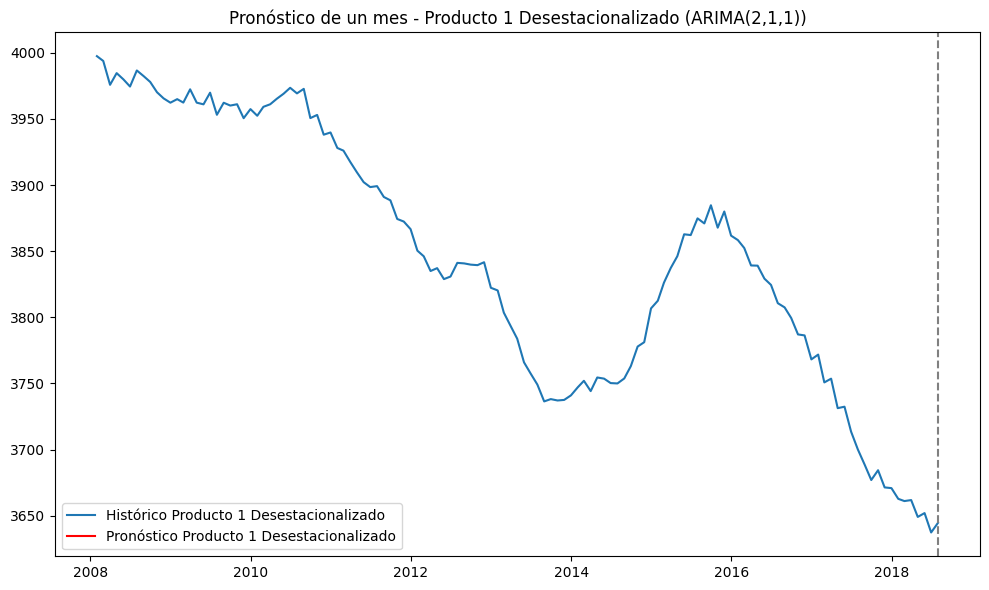

2018-07-31    3638.38425
Freq: M, dtype: float64


In [50]:
# Seleccionar la serie temporal desestacionalizada del producto 1
producto1_desestacionalizado = data['producto1_desestacionalizado']

# Dividir los datos en entrenamiento y prueba (último mes como prueba)
train_size = len(producto1_desestacionalizado) - 1
train_producto1_des = producto1_desestacionalizado[:train_size]
test_producto1_des = producto1_desestacionalizado[train_size:]

# Construcción del modelo ARIMA para producto1 desestacionalizado con los parámetros (p=2, d=1, q=1)
model_arima_p1_des = ARIMA(train_producto1_des, order=(2, 1, 1))

# Ajustar el modelo
model_fit_p1_des = model_arima_p1_des.fit()

# Hacer el pronóstico para el próximo mes
forecast_p1_des = model_fit_p1_des.forecast(steps=1)

# Graficar el pronóstico
plt.figure(figsize=(10, 6))
plt.plot(producto1_desestacionalizado, label='Histórico Producto 1 Desestacionalizado')
plt.axvline(producto1_desestacionalizado.index[-1], color='gray', linestyle='--')
plt.plot(forecast_p1_des.index, forecast_p1_des, label='Pronóstico Producto 1 Desestacionalizado', color='red')
plt.title('Pronóstico de un mes - Producto 1 Desestacionalizado (ARIMA(2,1,1))')
plt.legend()

plt.tight_layout()
plt.show()

# Mostrar el valor del pronóstico
print(forecast_p1_des)


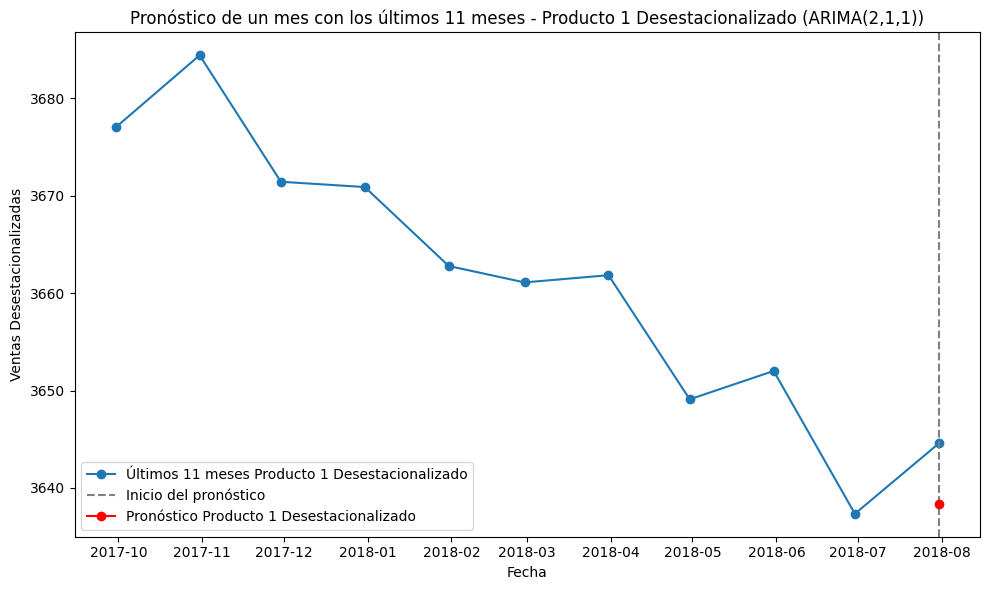

In [51]:
# Graficar los últimos 11 meses de datos históricos desestacionalizados y el pronóstico
plt.figure(figsize=(10, 6))

# Graficar los últimos 11 meses del histórico del Producto 1 desestacionalizado
plt.plot(producto1_desestacionalizado[-11:], label='Últimos 11 meses Producto 1 Desestacionalizado', marker='o')
plt.axvline(producto1_desestacionalizado.index[-1], color='gray', linestyle='--', label='Inicio del pronóstico')

# Agregar el pronóstico
plt.plot(forecast_p1_des.index, forecast_p1_des, label='Pronóstico Producto 1 Desestacionalizado', color='red', marker='o')

# Etiquetas y título
plt.title('Pronóstico de un mes con los últimos 11 meses - Producto 1 Desestacionalizado (ARIMA(2,1,1))')
plt.xlabel('Fecha')
plt.ylabel('Ventas Desestacionalizadas')
plt.legend()

# Mostrar la gráfica
plt.tight_layout()
plt.show()


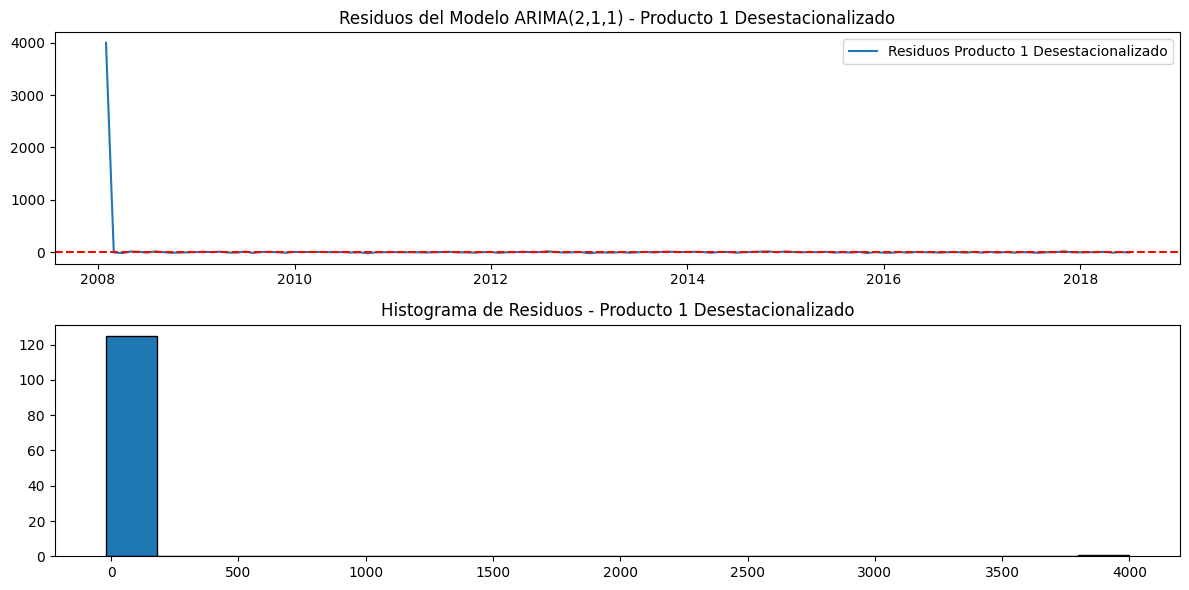

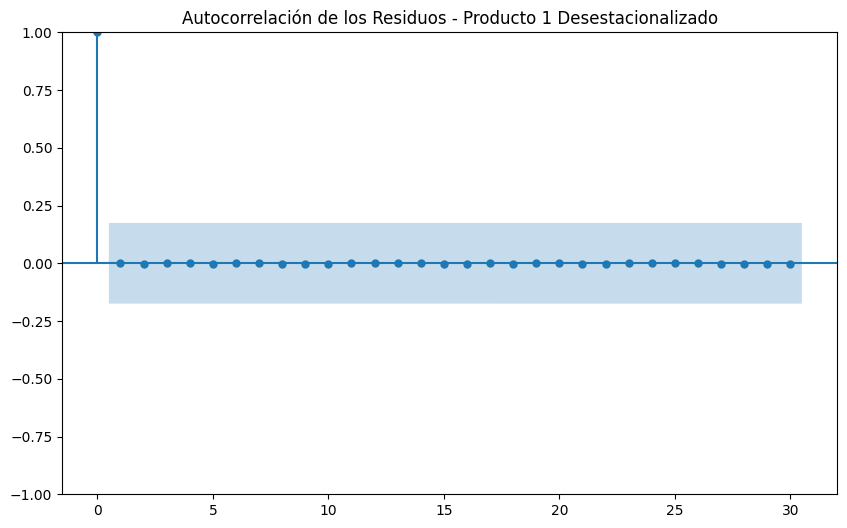

Prueba Shapiro-Wilk: Estadístico=0.07314294576644897, p-valor=1.2151682409353673e-24
Los residuos NO siguen una distribución normal.
Resultados de la prueba de Ljung-Box:
    lb_stat  lb_pvalue
10   0.0086        1.0


In [52]:
# Realizar el análisis de residuos
residuals_p1_des = model_fit_p1_des.resid

# Graficar los residuos para analizar su comportamiento
plt.figure(figsize=(12, 6))

# Gráfico de los residuos
plt.subplot(2, 1, 1)
plt.plot(residuals_p1_des, label='Residuos Producto 1 Desestacionalizado')
plt.axhline(0, linestyle='--', color='red')
plt.title('Residuos del Modelo ARIMA(2,1,1) - Producto 1 Desestacionalizado')
plt.legend()

# Histograma de los residuos
plt.subplot(2, 1, 2)
plt.hist(residuals_p1_des, bins=20, edgecolor='black')
plt.title('Histograma de Residuos - Producto 1 Desestacionalizado')

plt.tight_layout()
plt.show()

# Pruebas adicionales: ACF y Ljung-Box para los residuos


# Autocorrelación de los residuos
fig, ax = plt.subplots(figsize=(10, 6))
sm.graphics.tsa.plot_acf(residuals_p1_des, lags=30, ax=ax)
plt.title('Autocorrelación de los Residuos - Producto 1 Desestacionalizado')
plt.show()

# Prueba de normalidad Shapiro-Wilk
stat, p_value = shapiro(residuals_p1_des)
print(f'Prueba Shapiro-Wilk: Estadístico={stat}, p-valor={p_value}')
if p_value > 0.05:
    print('Los residuos parecen seguir una distribución normal.')
else:
    print('Los residuos NO siguen una distribución normal.')

# Prueba de autocorrelación Ljung-Box
ljung_box_result = acorr_ljungbox(residuals_p1_des, lags=[10], return_df=True)
print(f'Resultados de la prueba de Ljung-Box:\n{ljung_box_result}')



Interpretación:

- lb_stat: Es el valor calculado de la prueba. No es directamente interpretado, pero en general, valores pequeños indican poca evidencia de autocorrelación.

- lb_pvalue: Este es el valor clave para hacer la interpretación. En tu caso, tienes un p-valor de 1.0, lo que significa que no hay evidencia significativa de autocorrelación en los residuos.

Conclusión:
- Dado que el p-valor es muy alto (1.0), podemos concluir que no hay autocorrelación significativa en los residuos. Esto significa que los residuos del modelo se comportan como ruido blanco, lo cual es un buen indicador de que el modelo ARIMA está bien ajustado y no tiene dependencias o patrones no capturados en los residuos.

En resumen, el modelo parece estar ajustado correctamente desde el punto de vista de la autocorrelación de los residuos.

### **9.3 PRODUCTO2**

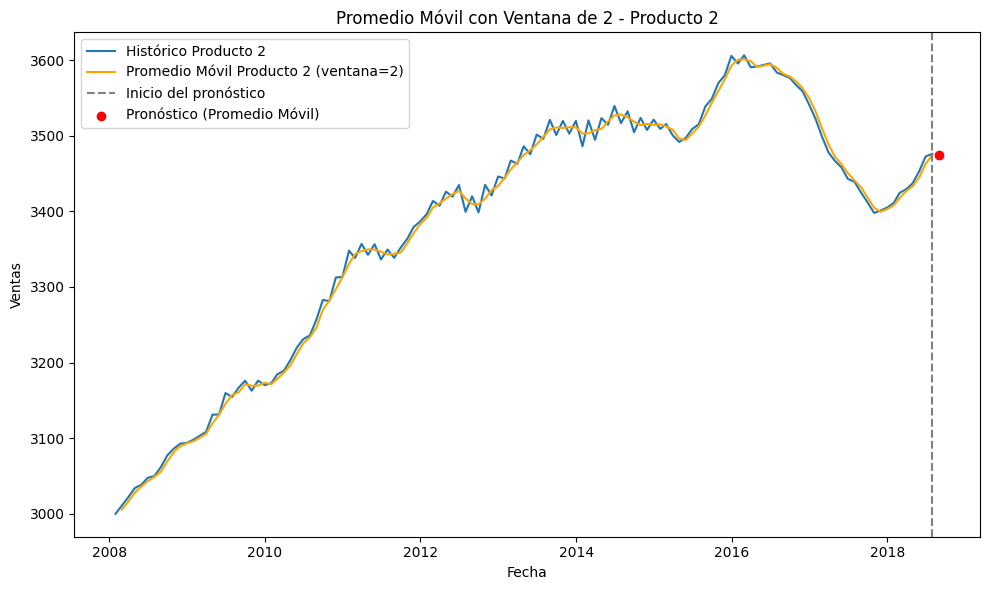

Pronóstico de Producto 2 (Promedio Móvil): 3474.293218407335


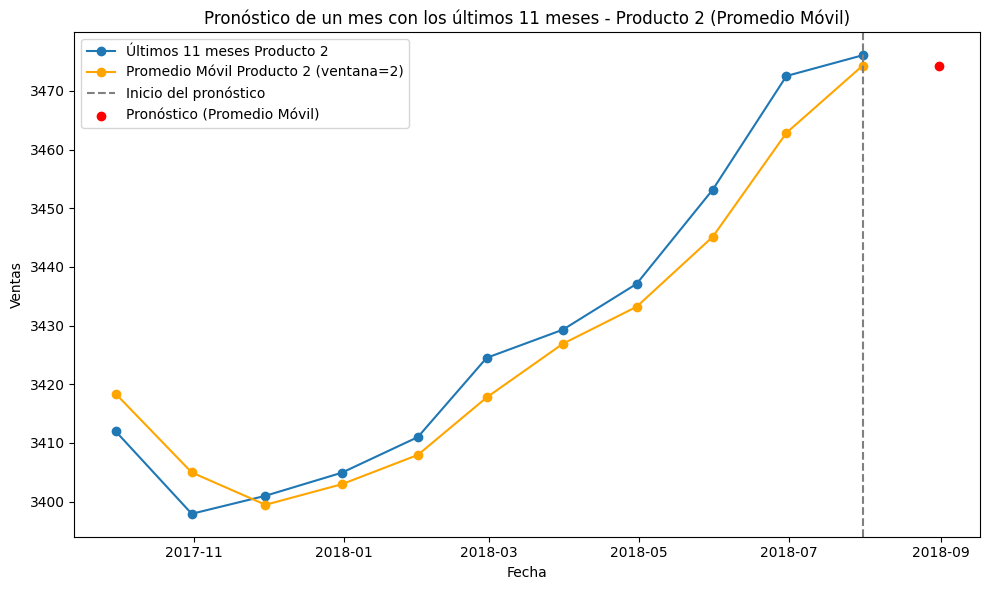

In [53]:
# Seleccionar la serie temporal del producto 2
producto2 = data['producto2']

# Calcular el promedio móvil con una ventana de tamaño 2
producto2_moving_avg = producto2.rolling(window=2).mean()

# Generar el pronóstico (usamos el valor promedio de los últimos dos meses)
forecast_p2_moving_avg = producto2[-2:].mean()

# Graficar el histórico de Producto 2 y su promedio móvil
plt.figure(figsize=(10, 6))
plt.plot(producto2, label='Histórico Producto 2')
plt.plot(producto2_moving_avg, label='Promedio Móvil Producto 2 (ventana=2)', color='orange')
plt.axvline(producto2.index[-1], color='gray', linestyle='--', label='Inicio del pronóstico')

# Agregar el pronóstico a la gráfica
plt.scatter(producto2.index[-1] + pd.DateOffset(months=1), forecast_p2_moving_avg, label='Pronóstico (Promedio Móvil)', color='red')

# Etiquetas y título
plt.title('Promedio Móvil con Ventana de 2 - Producto 2')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()

# Mostrar la gráfica
plt.tight_layout()
plt.show()

# Mostrar el valor del pronóstico
print(f'Pronóstico de Producto 2 (Promedio Móvil): {forecast_p2_moving_avg}')

# Graficar los últimos 11 meses y el pronóstico
plt.figure(figsize=(10, 6))

# Graficar los últimos 11 meses del histórico del Producto 2
plt.plot(producto2[-11:], label='Últimos 11 meses Producto 2', marker='o')
plt.plot(producto2_moving_avg[-11:], label='Promedio Móvil Producto 2 (ventana=2)', color='orange', marker='o')

# Agregar el pronóstico
plt.axvline(producto2.index[-1], color='gray', linestyle='--', label='Inicio del pronóstico')
plt.scatter(producto2.index[-1] + pd.DateOffset(months=1), forecast_p2_moving_avg, label='Pronóstico (Promedio Móvil)', color='red')

# Etiquetas y título
plt.title('Pronóstico de un mes con los últimos 11 meses - Producto 2 (Promedio Móvil)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()

# Mostrar la gráfica
plt.tight_layout()
plt.show()


Aunque este modelo no necesita cumplir supuestos haremos tambíen su análisis de residuos como labor meramente académica

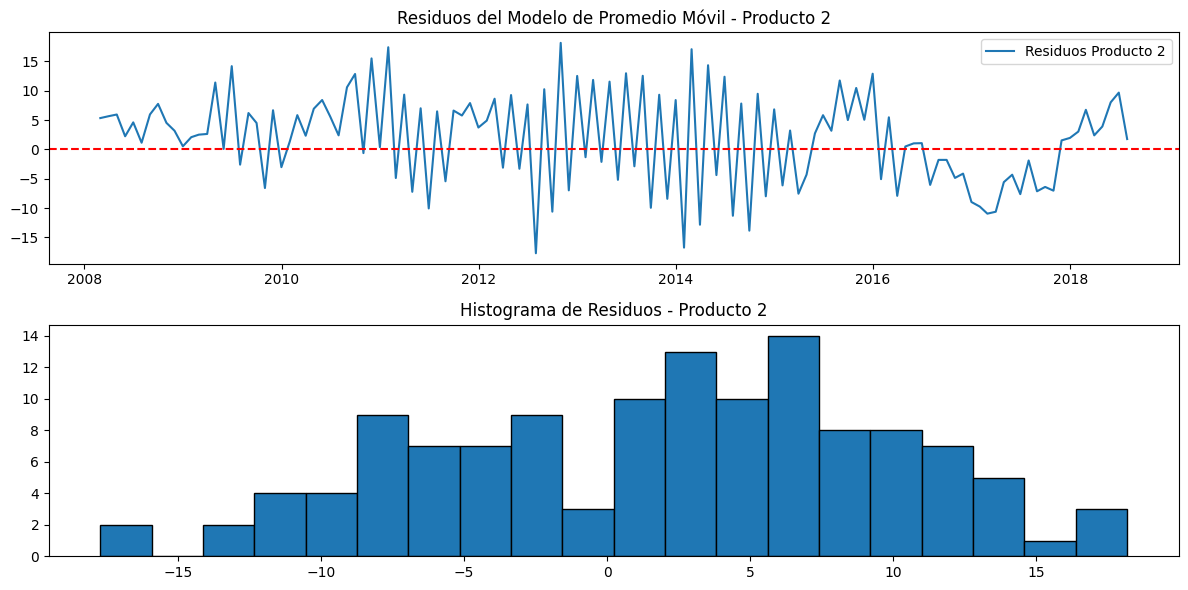

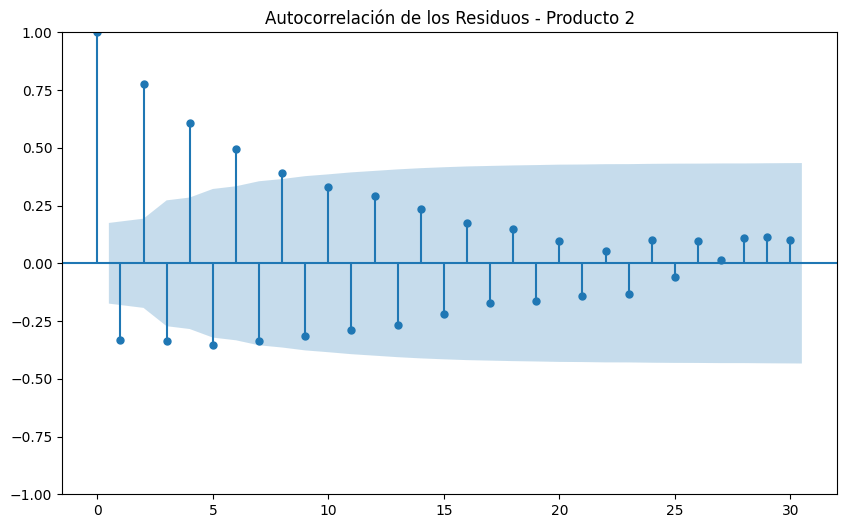

Prueba Shapiro-Wilk: Estadístico=0.9845964312553406, p-valor=0.1643325239419937
Los residuos parecen seguir una distribución normal.
Resultados de la prueba de Ljung-Box:
       lb_stat     lb_pvalue
10  270.960344  2.098540e-52


In [54]:
# Calcular los residuos como la diferencia entre los valores reales y los ajustados por el promedio móvil
residuals_p2 = producto2[1:] - producto2_moving_avg[1:]

# 1. Graficar los residuos
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(residuals_p2, label='Residuos Producto 2')
plt.axhline(0, linestyle='--', color='red')
plt.title('Residuos del Modelo de Promedio Móvil - Producto 2')
plt.legend()

# 2. Histograma de los residuos
plt.subplot(2, 1, 2)
plt.hist(residuals_p2.dropna(), bins=20, edgecolor='black')
plt.title('Histograma de Residuos - Producto 2')

plt.tight_layout()
plt.show()

# 3. Autocorrelación de los residuos
fig, ax = plt.subplots(figsize=(10, 6))
sm.graphics.tsa.plot_acf(residuals_p2.dropna(), lags=30, ax=ax)
plt.title('Autocorrelación de los Residuos - Producto 2')
plt.show()

# 4. Prueba de normalidad Shapiro-Wilk
stat, p_value = shapiro(residuals_p2.dropna())
print(f'Prueba Shapiro-Wilk: Estadístico={stat}, p-valor={p_value}')
if p_value > 0.05:
    print('Los residuos parecen seguir una distribución normal.')
else:
    print('Los residuos NO siguen una distribución normal.')

# 5. Prueba de autocorrelación Ljung-Box
ljung_box_result = acorr_ljungbox(residuals_p2.dropna(), lags=[10], return_df=True)
print(f'Resultados de la prueba de Ljung-Box:\n{ljung_box_result}')


Interpretación:
- lb_stat: Este es el valor estadístico de la prueba de Ljung-Box. En general, un valor alto indica que hay evidencia de autocorrelación en los residuos.
- lb_pvalue: El valor p asociado a la prueba es extremadamente bajo (
2.09854×10−52), lo que significa que la probabilidad de que los residuos no tengan autocorrelación es prácticamente nula.

Conclusión:
- El p-valor extremadamente bajo (mucho menor que 0.05) indica que hay autocorrelación significativa en los residuos. Esto sugiere que el modelo de promedio móvil con ventana de 2 no ha capturado toda la estructura de la serie de tiempo, y los residuos no son ruido blanco.

Esto significa que el modelo presenta deficiencias y podríamos considerar:

Probar un modelo más complejo que capture mejor la estructura de la serie.
Ajustar un modelo ARIMA o un modelo con tendencia o estacionalidad, si estos factores están presentes en los datos.
En resumen, el modelo de promedio móvil no es adecuado para capturar todas las dependencias presentes en la serie de tiempo del producto 2, ya que los residuos presentan autocorrelación significativa.

Justamente es lo que haremos para esta serie en específico en un punto adicional 10.


### **9.4 PRODUCTO2 DESESTACIONALIZADO**

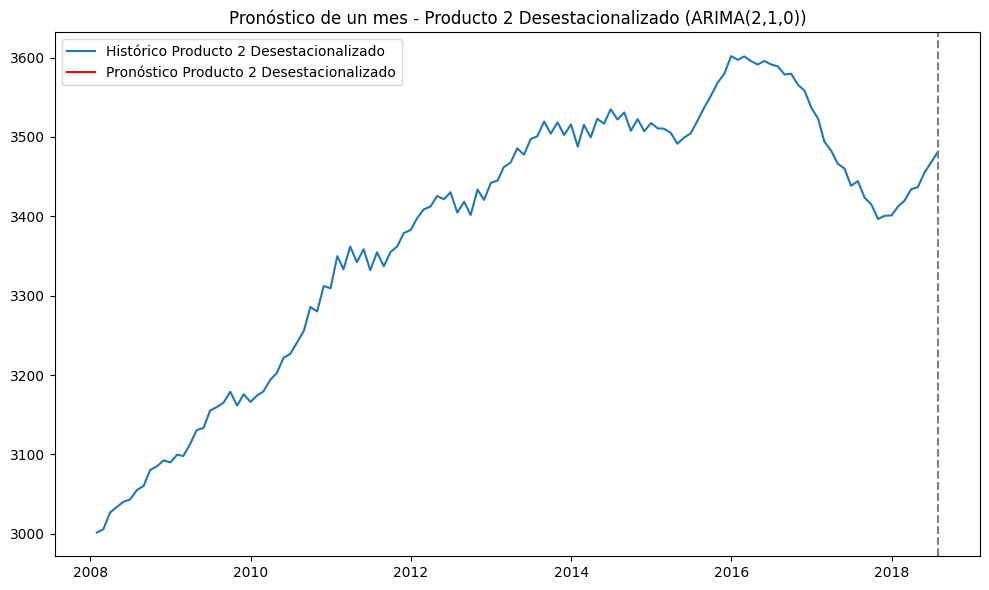

2018-07-31    3482.330319
Freq: M, dtype: float64


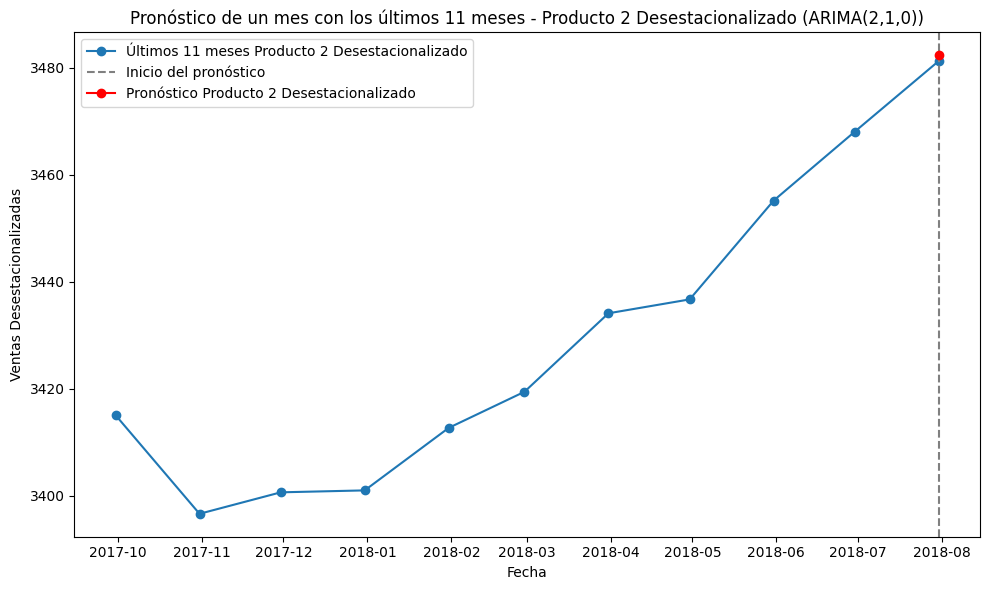

In [55]:
# Seleccionar la serie temporal desestacionalizada del producto 2
producto2_desestacionalizado = data['producto2_desestacionalizado']

# Dividir los datos en entrenamiento y prueba (último mes como prueba)
train_size = len(producto2_desestacionalizado) - 1
train_producto2_des = producto2_desestacionalizado[:train_size]
test_producto2_des = producto2_desestacionalizado[train_size:]

# Construcción del modelo ARIMA para producto2 desestacionalizado con los parámetros (p=2, d=1, q=0)
model_arima_p2_des = ARIMA(train_producto2_des, order=(2, 1, 0))

# Ajustar el modelo
model_fit_p2_des = model_arima_p2_des.fit()

# Hacer el pronóstico para el próximo mes
forecast_p2_des = model_fit_p2_des.forecast(steps=1)

# Graficar el pronóstico
plt.figure(figsize=(10, 6))
plt.plot(producto2_desestacionalizado, label='Histórico Producto 2 Desestacionalizado')
plt.axvline(producto2_desestacionalizado.index[-1], color='gray', linestyle='--')
plt.plot(forecast_p2_des.index, forecast_p2_des, label='Pronóstico Producto 2 Desestacionalizado', color='red')
plt.title('Pronóstico de un mes - Producto 2 Desestacionalizado (ARIMA(2,1,0))')
plt.legend()

plt.tight_layout()
plt.show()

# Mostrar el valor del pronóstico
print(forecast_p2_des)

# Graficar los últimos 11 meses y el pronóstico
plt.figure(figsize=(10, 6))

# Graficar los últimos 11 meses del histórico del Producto 2 desestacionalizado
plt.plot(producto2_desestacionalizado[-11:], label='Últimos 11 meses Producto 2 Desestacionalizado', marker='o')

# Agregar el pronóstico
plt.axvline(producto2_desestacionalizado.index[-1], color='gray', linestyle='--', label='Inicio del pronóstico')
plt.plot(forecast_p2_des.index, forecast_p2_des, label='Pronóstico Producto 2 Desestacionalizado', color='red', marker='o')

# Etiquetas y título
plt.title('Pronóstico de un mes con los últimos 11 meses - Producto 2 Desestacionalizado (ARIMA(2,1,0))')
plt.xlabel('Fecha')
plt.ylabel('Ventas Desestacionalizadas')
plt.legend()

# Mostrar la gráfica
plt.tight_layout()
plt.show()

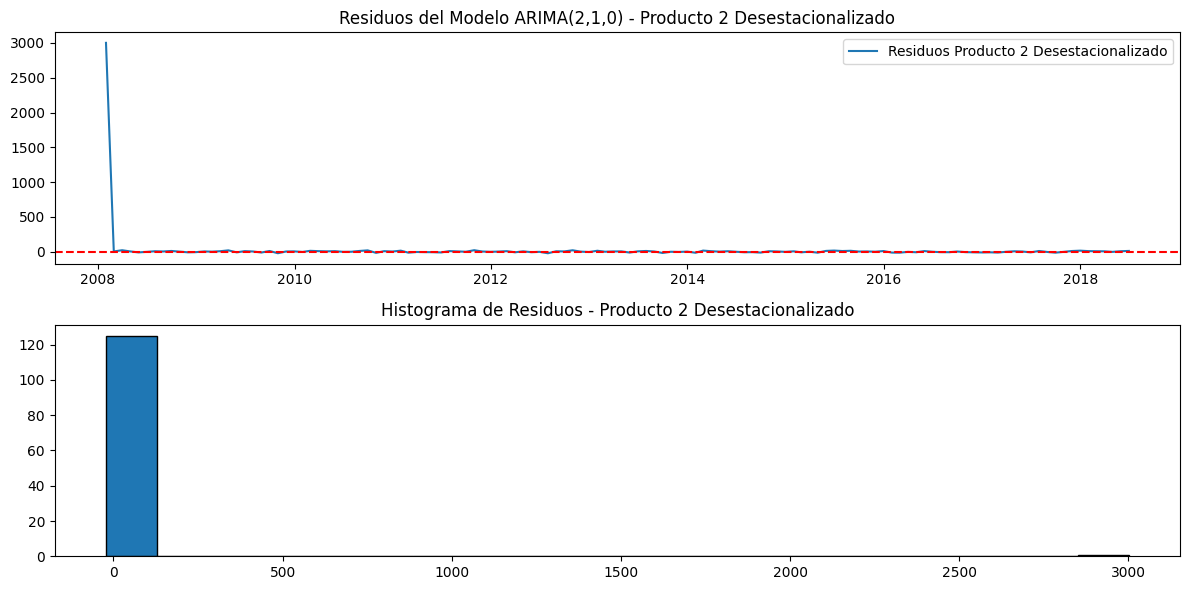

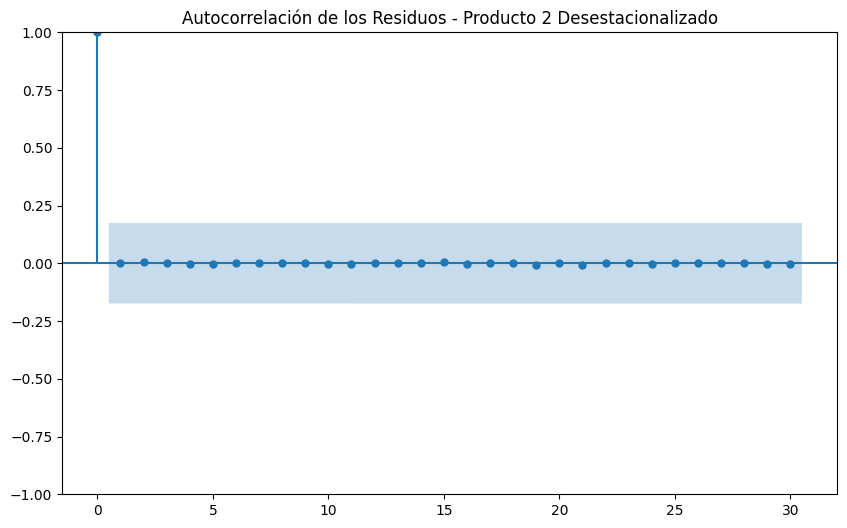

Prueba Shapiro-Wilk: Estadístico=0.08069288730621338, p-valor=1.467445465386981e-24
Los residuos NO siguen una distribución normal.
Resultados de la prueba de Ljung-Box:
     lb_stat  lb_pvalue
10  0.011648        1.0


In [56]:
# Realizar el análisis de residuos
residuals_p2_des = model_fit_p2_des.resid

# Graficar los residuos para analizar su comportamiento
plt.figure(figsize=(12, 6))

# Gráfico de los residuos
plt.subplot(2, 1, 1)
plt.plot(residuals_p2_des, label='Residuos Producto 2 Desestacionalizado')
plt.axhline(0, linestyle='--', color='red')
plt.title('Residuos del Modelo ARIMA(2,1,0) - Producto 2 Desestacionalizado')
plt.legend()

# Histograma de los residuos
plt.subplot(2, 1, 2)
plt.hist(residuals_p2_des, bins=20, edgecolor='black')
plt.title('Histograma de Residuos - Producto 2 Desestacionalizado')

plt.tight_layout()
plt.show()

# Pruebas adicionales: ACF y Ljung-Box para los residuos
import statsmodels.api as sm
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import acorr_ljungbox

# Autocorrelación de los residuos
fig, ax = plt.subplots(figsize=(10, 6))
sm.graphics.tsa.plot_acf(residuals_p2_des.dropna(), lags=30, ax=ax)
plt.title('Autocorrelación de los Residuos - Producto 2 Desestacionalizado')
plt.show()

# Prueba de normalidad Shapiro-Wilk
stat, p_value = shapiro(residuals_p2_des.dropna())
print(f'Prueba Shapiro-Wilk: Estadístico={stat}, p-valor={p_value}')
if p_value > 0.05:
    print('Los residuos parecen seguir una distribución normal.')
else:
    print('Los residuos NO siguen una distribución normal.')

# Prueba de autocorrelación Ljung-Box
ljung_box_result = acorr_ljungbox(residuals_p2_des.dropna(), lags=[10], return_df=True)
print(f'Resultados de la prueba de Ljung-Box:\n{ljung_box_result}')


Interpretación de los resultados de las pruebas de residuos:

- Prueba de normalidad Shapiro-Wilk:

    -	Estadístico: 0.0807
    -	p-valor: 1.467445465386981e-24

Conclusión: 
- El p-valor extremadamente bajo indica que los residuos no siguen una distribución normal. Esto puede significar que hay ciertos patrones o características no capturados por el modelo. La normalidad de los residuos es importante porque indica si los errores son aleatorios y bien distribuidos.

- Prueba de autocorrelación Ljung-Box:
    -	lb_stat: 0.011648
    -	p-valor: 1.0

Conclusión: 
- El p-valor alto (1.0) sugiere que no hay autocorrelación significativa en los residuos. Esto es un buen indicador, ya que implica que el modelo ha capturado bien las dependencias en los datos, y los residuos son ruido blanco (no correlacionados).
Resumen:

-	Aunque los residuos no siguen una distribución normal, lo cual puede indicar que el modelo ARIMA(2,1,0) no ha capturado completamente la estructura de la serie, el hecho de que no haya autocorrelación en los residuos (según la prueba de Ljung-Box) es un buen signo. Esto indica que el modelo ha capturado bien las relaciones de dependencia temporal.

Conclusión general:
- Fortalezas: No hay autocorrelación en los residuos, lo que sugiere que el modelo ha capturado bien la estructura de los datos.
- Debilidades: Los residuos no siguen una distribución normal, lo que puede implicar que algunos patrones en los datos no han sido completamente modelados. Podrías considerar investigar la causa de la no normalidad en los residuos, como la presencia de valores atípicos o cambios estructurales no capturados.

Si el propósito del modelo es generar pronósticos razonables y no se espera que los residuos sean perfectamente normales, este modelo aún puede ser adecuado, aunque no perfecto. Si la normalidad de los residuos es un requerimiento importante, quizás podríamos probar otros enfoques o modelos más complejos.

